In [ ]:
# default_exp multifidelitysm

# Multi-Fidelity Surrogate Model Comparison - Kriging vs. Deep Neural Net (DNN) 
This code seeks to compare the data compression, accuracy, portability, and evaluation time for two different types of surrogate modeling techniques: Kriging and Deep Neural Nets (DNN). First, we will build single fidelity models based on the RANS data (our high fidelity data set), then we will build single fidelity models based on local methods (low fidelity data set). Finally, we will build multi-fidelity models combining the data from both models. 

Our goal is to beat the performance of the single fidelity model, and also potentially explore how much of the high fidelity data is needed--maybe we can match the performace of the single fidelity model, but with significantly less data. 

In [ ]:
#hide
from nbdev.showdoc import *

# Imports and Functions

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'#Supress TensorFlow debug info. We don't have a GPU or TPU, 
                                        #and if TensorFlow doesn't find one, it gets upset
import code
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6); plt.rcParams['axes.grid'] = True; plt.rcParams['figure.dpi'] = 300; plt.rcParams['axes.labelsize'] = 'xx-large';
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
import tensorflow as tf
import warnings
import tqdm
import sklearn
import math
import datetime
import copy
import time
import random
import scipy


from tqdm.keras import TqdmCallback
from sklearn import preprocessing
from sklearn import gaussian_process
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, RationalQuadratic
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import qmc

Functions Block - run this block before running the rest of the notebook 

In [ ]:
# def latinHypercubeSample(dimensionParameterSpace, numPointsToSample,l_bounds,u_bounds,seed):
#     """

#     :param dimensionParameterSpace: 
#     :param numPointsToSample: 
#     :param l_bounds: 
#     :param u_bounds: 
#     :return:
#     """
#     sampler = qmc.LatinHypercube(d=dimensionParameterSpace, seed=seed)
#     sample = sampler.random(n=numPointsToSample)
#     sample.shape
#     # Wall Temp, rho, free stream temp, free stream velocity
#     lowFidelityInputPoints = qmc.scale(sample, l_bounds, u_bounds)
#     return lowFidelityInputPoints

def variableChecker(stringToTest):
    if stringToTest in globals():
        print('Global variable')
    else: 
        print('Not global variable')

    if stringToTest in locals():
        print('Local variable')
    else: 
        print('Not local variable')

#Oblique Perfect Gas Function 
def perfgas_oblique(M,V1,T1,P1,rho_1,a1,theta):
    
    gamma = 1.4 # perfect gas
    R_specific = 287.058
    cp1 = 1.005 #KJ/Kg*K, air at 251K
    #For our initial guess at beta, let's use the M>>1 approximation. Although
    #our flow M>>1, this code will calculate a more accurate turn angle than the approximation. 
    b_init = ((gamma + 1) / 2)*theta

    #We'll use Newton's method, which requires the function and the function's 
    #derivative, included below as "f" and "fp"
    #  tan(theta) = 2cot(beta)*(M^2sin^2(beta) - 1)/(M^2(gamma + cos(2beta) + 1)

    b = np.zeros((11,1))
    i = 1
    b[i] = b_init
    
    for i in range(1,10):
        b[i+1] = b[i] - ((2*(1/np.tan(b[i]))*(M**2*(np.sin(b[i]))**2-1))/(M**2*(gamma + np.cos(2*b[i]))+2)-np.tan(theta))
        / ((4*M**2*np.sin(2*b[i])*(1/np.tan(b[i]))*(M**2*np.sin(b[i])**2-1))/((M**2*(np.cos(2*b[i])+gamma)+2)**2)
           + (4*M**2*np.cos(b[i])**2 - 2*(1/np.cos(b[i]))**2*(M**2*(np.sin(b[i]))**2-1))/(M**2*(np.cos(2*b[i])+gamma)+2))

            
    beta = b[10]
    # beta_deg = np.rad2deg(b[10])

    M1 = M
    M2 = np.sqrt(((1+((gamma-1)/2)*(M1**2)*(np.sin(beta)**2)) / (gamma*(M1**2)*(np.sin(beta)**2)-((gamma-1)/2)))
        * (1/(np.sin(beta-theta)**2)))
    m_ratio = M2/M1

    temp_ratio = 1 + ((2*(gamma-1))/((gamma+1)**2))*(((M1**2)*(np.sin(beta)**2) - 1)/((M1**2)*(np.sin(beta)**2)))*(gamma*(M1**2)*(np.sin(beta)**2)+1)
    T2 = temp_ratio*T1

    H2 = cp1*T2*1000

    #Using the relation T2/T1 = (a2/a1)^2, we can also solve for the ratio of
    #a2/a1 
    a_ratio = np.sqrt(temp_ratio)
    a2 = a_ratio*a1

    rho_ratio = ((gamma+1)*(M1**2)*(np.sin(beta)**2))/((gamma-1)*(M1**2)*(np.sin(beta)**2)+2)
    rho2 = rho_ratio*rho_1

    v_ratio = m_ratio* a_ratio
    V2 = v_ratio*V1

    p_ratio = rho_ratio*temp_ratio
    P2 = p_ratio*P1

    T01 = T1*(1+ ((gamma-1)/2)*(M1**2))
    T02 = T2*(1+ ((gamma-1)/2)*(M2**2))

    total_p_ratio = p_ratio * ((1+((gamma-1)/2)*(M2**2))**(gamma/(gamma-1)))/((1+((gamma-1)/2)*(M1**2))**(gamma/(gamma-1)))
    P01 = P1* ((1 +((gamma-1)/2)*(M1**2))**((gamma)/(gamma-1)))
    P02 = P01*total_p_ratio
    
    return H2, V2, T2, P2, rho2, beta, M2,a2, T01, T02, P01, P02

def mu_suth(T):
    mu_ref = 1.8e-5
    T_ref = 300
    mu = mu_ref*((T/T_ref)**0.7)
    return mu

# Neural Network Functions
def build_model_single_fidelity(inputData, outputData, numOutputData, layer1size, layer2Size, rate, reg):
    """

    :param inputData: input parameters/features (only one (!!!!) of the arrays, not all of them)
    :param outputData: the outputs the NN is fitting (only one (!!!!) of the arrays, not all of them)
    :param numOutputData: number of outputs the NN will have
    :param layer1size: reference size for building the NN model
    :param layer2size: reference size for building the NN model
    :param rate: learning rate
    :param reg: L2 regularization value to drop weights
    :return:
    """

    inputlayershape = int(len(inputData[0,:]))
    outputlayershape = int(len(outputData[0,:]))
    
    T_w = tf.keras.Input(shape=(inputlayershape,), name = 'walltemp')
    rho = tf.keras.Input(shape=(inputlayershape,), name = 'freestream_density')
    T_inf = tf.keras.Input(shape=(inputlayershape,), name = 'freestream_temp')
    u_inf = tf.keras.Input(shape=(inputlayershape,), name = 'freestream_velocity')
    
    inputs = [T_w, rho , T_inf,u_inf]
    
    features = layers.Concatenate()(inputs)
    
    x = tf.keras.layers.Dense(layer1size,activation=tf.nn.tanh,
                kernel_regularizer=keras.regularizers.l2(reg),
                kernel_initializer = tf.keras.initializers.GlorotUniform()
                )(features)
    
    x = tf.keras.layers.Dense(layer2size,activation=tf.nn.tanh,
                kernel_regularizer=keras.regularizers.l2(reg),
                kernel_initializer = tf.keras.initializers.GlorotUniform()
                )(x)
    
#     x = tf.keras.layers.Dense(layer3_size,activation=tf.nn.tanh,
#                 kernel_regularizer=keras.regularizers.l2(reg),
#                 kernel_initializer = tf.keras.initializers.GlorotUniform()
#                 )(x)
    
    qw_layer = tf.keras.layers.Dense(outputlayershape,activation=tf.nn.leaky_relu,
                      kernel_regularizer= keras.regularizers.l2(reg),
                      kernel_initializer = tf.keras.initializers.GlorotUniform(),
                                     name = 'wall_heat_transfer')(x)
    
    
    P_layer = tf.keras.layers.Dense(outputlayershape, activation=tf.nn.leaky_relu,
                  kernel_regularizer= keras.regularizers.l2(reg),
                  kernel_initializer = tf.keras.initializers.GlorotUniform()
                                    , name='wall_pressure')(x)
    
    outputs = [qw_layer, P_layer]
    
    model = tf.keras.Model(inputs=inputs,outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=rate),
             loss = "mse",
             metrics = [tf.keras.metrics.MeanSquaredError(),
                       tf.keras.metrics.RootMeanSquaredError(),])
                       # "mae"])
    tf.keras.utils.plot_model(model,show_shapes=True)
    return model

#Building the model
def build_model_multi_fidelity(input_data, output_data, ref_size, rate, reg):
    """

    :param input_data: input parameters/features
    :param output_data: outputs the NN is fitting
    :param ref_size: reference size for building the NN model
    :param rate: learning rate
    :param reg: L2 regularization value to drop weights
    :return:
    """
    inputlayershape = int(len(input_data[0,:]))
    outputlayershape = int(len(output_data[0,:]))

    layer1_size = ref_size
#     layer2_size = ref_size
#     layer3_size = ref_size
    inputs = tf.keras.Input(shape=(inputlayershape,))
    
    x = tf.keras.layers.Dense(layer1_size,activation=tf.nn.tanh,
                kernel_regularizer=keras.regularizers.l2(reg),
                kernel_initializer = tf.keras.initializers.GlorotUniform()
                )(inputs)
    x = tf.keras.layers.Dense(layer1_size,activation=tf.nn.tanh,
                kernel_regularizer=keras.regularizers.l2(reg),
                kernel_initializer = tf.keras.initializers.GlorotUniform()
                )(x)
    x = tf.keras.layers.Dense(layer1_size,activation=tf.nn.tanh,
                kernel_regularizer=keras.regularizers.l2(reg),
                kernel_initializer = tf.keras.initializers.GlorotUniform()
                )(x)

    x = tf.keras.layers.Dense(layer1_size,activation=tf.nn.tanh,
                kernel_regularizer=keras.regularizers.l2(reg),
                kernel_initializer = tf.keras.initializers.GlorotUniform()
                )(x)
    x = tf.keras.layers.Dense(layer1_size,activation=tf.nn.tanh,
                kernel_regularizer=keras.regularizers.l2(reg),
                kernel_initializer = tf.keras.initializers.GlorotUniform()
                )(x)

    x = tf.keras.layers.Dense(layer1_size,activation=tf.nn.tanh,
                kernel_regularizer=keras.regularizers.l2(reg),
                kernel_initializer = tf.keras.initializers.GlorotUniform()
                )(x)

    #     x = tf.keras.layers.Dense(layer3_size,activation=tf.nn.tanh,
#                 kernel_regularizer=keras.regularizers.l2(reg),
#                 kernel_initializer = tf.keras.initializers.GlorotUniform()
#                 )(x)

    # Repeat the "x = ...(x) " pattern to generate more layers if desired   
   
    qw_layer = tf.keras.layers.Dense(outputlayershape,activation=tf.nn.leaky_relu,
                      kernel_regularizer= keras.regularizers.l2(reg),
                      kernel_initializer = tf.keras.initializers.GlorotUniform(),
                                     name = 'wall_heat_transfer')(x)
    
    
    P_layer = tf.keras.layers.Dense(outputlayershape, activation=tf.nn.leaky_relu,
                  kernel_regularizer= keras.regularizers.l2(reg),
                  kernel_initializer = tf.keras.initializers.GlorotUniform()
                                    , name='wall_pressure')(x)
    
    outputs = [qw_layer, P_layer]

    # outputs = tf.keras.layers.Dense(outputlayershape, activation=tf.nn.leaky_relu,
    #                   kernel_regularizer= keras.regularizers.l2(reg),
    #                   kernel_initializer = tf.keras.initializers.GlorotUniform())(x)
    
    model = tf.keras.Model(inputs=inputs,outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=rate),
             loss = "mse",
             metrics = [tf.keras.metrics.MeanSquaredError(),
                       tf.keras.metrics.RootMeanSquaredError(),])
                       # "mae"])
    tf.keras.utils.plot_model(model,show_shapes=True)
    return model

#training the model 

# tqdm_callback = tfa.callbacks.TQDMProgressBar()

def train_model_all_fidelity(model, input_data, output_data, numEpochs, myBatchSize, validSplit):
    callbacks_list = [
        # keras.callbacks.EarlyStopping(
        # monitor = "root_mean_squared_error",mode="min",
        # patience=1000, verbose=2),
        TqdmCallback(verbose=1)
#         keras.callbacks.ModelCheckpoint(
#         filepath=checkpoint_path.keras,
#         monitor="mean_squared_error")
#         keras.callbacks.LearningRateScheduler(scheduler
#         )
    ]
    
    history = model.fit(x=input_data,
                       y=output_data,
                       batch_size=myBatchSize,
                       epochs=numEpochs,
                       callbacks = callbacks_list,
                       verbose=False,
                       shuffle=False,
                       validation_split=validSplit,
                       use_multiprocessing=True)
    epochs = history.epoch
    return epochs, history.history

def oneToOneVisualizationPlot(case):
    plt.rcParams["figure.figsize"] = (15,5)
    fig, axs = plt.subplots(1, 2)
    fig.tight_layout(pad=0.4, w_pad=1.5, h_pad=.5)
    fig.patch.set_facecolor('white')

    elbowLocation = 2.35
    case = case
    cm = plt.cm.get_cmap('cool')
    zmax = 2.5
    z = np.arange(0,zmax, zmax/qw_HF_krig_test_predict[case,:].shape[0])
    #plot one case only
    labelstr = 'Mach inf: ' + str(M_inf_test[case]) + ',case:' + str(case)
    maxHeatTransfer = qw_HF_krig_test_predict[case,:].max()
    maxPressure = p_HF_krig_test_predict[case,:].max()
    x = qw_HF_krig_test_predict[case,:]/maxHeatTransfer
    y = qw_HF_test_truth[case,:]/maxHeatTransfer
    sc = axs[0].scatter(x, y ,c = z, s=80, label = labelstr, 
                     cmap=cm,edgecolors='none',vmin=0,vmax=2.5 )
    cbar = fig.colorbar(sc,ax = axs[0])
    cbar.ax.set_title("x-location (meters)")
    cbar.ax.plot([0, zmax], [elbowLocation]*2, 'w')
    axs[0].plot([0, 1], [0, 1], color = 'k')

    qw_HF_krig_R2 = 'R2: ' + str(round(r2_score(qw_HF_test_truth[case,:], qw_HF_krig_test_predict[case,:]),4))

    axs[0].text(0.05, 0.85, qw_HF_krig_R2, transform=axs[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)
    axs[0].set_title("Heat Transfer Predicitions vs Actual")
    axs[0].grid()
    axs[0].set_ylabel("True Value")
    axs[0].set_xlabel("Predicted Heat Transfer")

    #############################################

    sliceVal = 20 # this is the "ol' fashioned way" for the plt.plot argument "markevery=sliceVal." The command doesn't work in plt.scatter

    maxHeatTransfer = qw_HF_krig_test_predict[case,:].max()
    maxPressure = p_HF_krig_test_predict[case,:].max()

    # plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
    axs[1].plot(x_cc_sorted[0,idxWindowStart:], qw_HF_test_truth[case,:]/maxHeatTransfer, color='firebrick', linestyle='solid', linewidth=4, label='RANS CFD Output (Truth Data)')

    axs[1].plot(x_cc_sorted[0,idxWindowStart:], qw_HF_krig_test_predict[case,:]/maxHeatTransfer, 
                color='black', linestyle='-.', linewidth=2, label='Kriging Predicition')
    axs[1].set_title("Predicted Heat Transfer",fontsize='x-large')
    axs[1].set_ylabel("qw / qw_max", fontsize='x-large')
    axs[1].set_xlabel('x (meters)')

    axs[1].legend(fontsize='x-large')
    
def normalizedRootMeanSquaredError(truth,prediction):
    rmse = mean_squared_error(truth, prediction, squared=False)
    ybar = truth.max()-truth.min()
    nrmse = rmse/ybar
    return nrmse

# Import data from CFD runs. 
If you have not run the post-processing scripts housed in the top folder, run those first. The below code assumes that all us3d output has been post-processed

In [ ]:
# Import the *input* data, i.e. what we tell the RANS code the initial state in front of our wedge is. 

path = "/home/tyty/Desktop/CFD_Files/AFRL_Scholars/1st_Round_Ls"
os.chdir(path)
# Provide the file name that holds your input data: 
fileName = '1st_Round_LS.cvs'

# First thing is to read in the data file
data = pd.read_csv(fileName)

# Convert the pandas dataframe to numpy and transpose
inputData = pd.DataFrame(data).to_numpy()
inputData = inputData.T

# Iteratively assign the input data names. The enumerate function has a second output, which I've stored 
# here with "i" that indexes your data for you, so you don't need to use an initialized counter (i=0)
# and then count with an i += 1 at the end. This section of code uses the locals()[] to turn a string
#into a variable so we can iteratively create variables.
inputVarNames = [
    'WallTemp',
    'Density',
    'Temperature',
    'Velocity',
]

l_bounds = []
u_bounds = []

for i, name in enumerate(inputVarNames):
    name = 'input' + name
    locals()[name] = inputData[i,:].reshape(-1,1)
    minInputVal = np.min(locals()[name])
    maxInputVal = np.max(locals()[name])
    l_bounds.append(minInputVal)
    u_bounds.append(maxInputVal)
    print( name + ' range from: ' + str(minInputVal) + ' to ' + str(maxInputVal) + '\n') 

inputWallTemp range from: 200.0 to 600.0

inputDensity range from: 0.01803 to 0.5

inputTemperature range from: 56.667 to 226.65

inputVelocity range from: 931.13 to 1871.24



### Input Data

A quick explanation of our models' input data 

inputWallTemp = wall temperature of double cone

inputDensity = free stream density

inputTemperature = free stream temperature

inputVelocity = free stream velocity

These values are all chosen by the user, and the values are fed to US3D to generate CFD results for the entire flowfield. To keep the data and the model light, we're only going to analyze the "wall" values., which in this case will be pressure and heat transfer (maybe eventually the shear stresses, too). 

### Generate Low-Fidelity Space Sample Points 

In [ ]:
dimensionParameterSpace = 4 # wall temp, free stream temp, free stream density, free stream velocity
numPointsToSample = 4000 
seed = 5 # seed with a number for reproducibility. It will be the same LHS sampling every time the function
        # is run using seed = x. 

lowFidelityInputPoints = latinHypercubeSample(
    dimensionParameterSpace,
    numPointsToSample,
    l_bounds,
    u_bounds,
    seed
)

In [ ]:
# Code that plots Low Fideltiy Input Space vs. High Fidelity Input Space  

# wallTempLimits = (400,450)
# densityLimits = (0.2,0.3)

# matplotlib.rcParams['figure.figsize'] = (5,5)
# plt.rcParams['legend.facecolor'] = 'black'
# plt.scatter(lowFidelityInputPoints[:,0],lowFidelityInputPoints[:,1], s=4, label = 'Low Fidelity Space Sample Points')
# plt.scatter(inputWallTemp[:],inputDensity[:], label = 'High Fidelity Space Sample Points', s=150)
# plt.xlabel("Wall Temp",fontsize='xx-large')
# plt.ylabel("Density",fontsize='xx-large')
# plt.grid()
# lgnd = plt.legend(loc='upper right', fontsize='large')
# for i in range(0,2):
#     lgnd.legendHandles[i]._sizes = [100]
    
# for text in lgnd.get_texts():
#     text.set_color("white")
# plt.xlim(wallTempLimits)
# plt.ylim(densityLimits)


# plt.rcParams["figure.figsize"] = (20,10)
# fig, axs = plt.subplots(2, 3)
# fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# fig.patch.set_facecolor('white')


# axs[0,0].scatter(lowFidelityInputPoints[:,0],lowFidelityInputPoints[:,1], s=1, label = 'Low Fidelity Space Sample Points')
# axs[0,0].scatter(inputWallTemp[:],inputDensity[:], label = 'High Fidelity Space Sample Points')
# axs[0,0].set_xlabel("Wall Temp")
# axs[0,0].set_ylabel("Density")
# axs[0,0].grid()
# axs[0,0].legend()

In [ ]:
# Import the *output* data, i.e. what the RANS code does with our input file. 
# Take these from the files 
path = "/home/tyty/Desktop/CFD_Files/MFmodelTestData"
os.chdir(path)

outputVarNames = [
    'x',
    'y',
    'z',
    'qw',
    'taux',
    'tauy',
    'tauz',
    'tauw',
    'yplus',
    'T',
    'p',
    'x_cc',
    'y_cc',
    'z_cc'
]
for name in outputVarNames:
    locals()[name] = None
    pickleName = './' + name + '.pkl'
    F = open(pickleName, 'rb')
    locals()[name] = pickle.load(F)
    locals()[name] = locals()[name].T
    # Uncomment the below line if you'd like confirmation that your data made it 
    # print(locals()[name].shape)

pickleName = './' + 'conn' + '.pkl'
F = open(pickleName, 'rb')    
connDict = pickle.load(F)

# Pruning our list of output variables to what we'll need for training, testing, and validation
outputVarNames = [
    'qw',
    'p',
]

for name in outputVarNames:
    max_element = str(round(np.max(locals()[name]),2))
    min_element = str(round(np.min(locals()[name]),2))
    print(name + ' has been imported! Min:' + min_element + '. Max:' + max_element)

qw has been imported! Min:-1275825.55. Max:167836511.1
p has been imported! Min:342.04. Max:1598150.31


# Windowing the Data

In [ ]:
# Do you desire to "window" the data and remove the pressure/heat transfer values from the nose region? If so, set Window to "True"
# If you desire to window the data, also select the location in which you'd like to do that. 
Window = True 

if Window:
    caseWePick = 389
    xWindowStart = 0.3
    xIndex = np.argsort(x_cc[0])
    x_cc_sorted = x_cc[:,xIndex]
    idxWindowStart = (np.abs(x_cc_sorted[0,:] - xWindowStart)).argmin()
    
    for name in outputVarNames:
        sortedName = name + '_sorted'
        windowedName = name + '_windowed'
        locals()[sortedName] = locals()[name][:,xIndex]
        locals()[windowedName] = locals()[sortedName][:,idxWindowStart:]
    
    x_cc_windowed = x_cc_sorted[:,idxWindowStart:]
    
#     plt.rcParams["figure.figsize"] = (20,5)
#     fig, axs = plt.subplots(1, 2)
#     fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)
#     fig.patch.set_facecolor('white')


#     axs[0].scatter(x_cc_sorted[caseWePick,idxWindowStart:], p_sorted[caseWePick,idxWindowStart:],s=30, label = 'Windowed Data')
#     axs[0].scatter(x_cc_sorted[caseWePick,:], p_sorted[caseWePick,:],s=3, label = 'Full Data')
#     axs[0].axvline(x=xWindowStart, linewidth=1, color='k', label = 'Chosen Start of Window')
#     axs[1].scatter(x_cc_sorted[caseWePick,idxWindowStart:], qw_sorted[caseWePick,idxWindowStart:],s=30, label = 'Windowed Data')
#     axs[1].scatter(x_cc_sorted[caseWePick,:], qw_sorted[caseWePick,:],s=3, label = 'Full Data')
#     axs[1].axvline(x=xWindowStart, linewidth=1, color='k', label = 'Chosen Start of Window')

#     axs[0].set_title("Pressure Window Results")
#     axs[0].set_ylabel("Pressure (Pa)")
#     axs[0].grid()
#     axs[1].set_title("Heat Transfer Window Results")
#     axs[1].set_ylabel('Heat Transfer (w/m^2')
#     axs[1].grid()

#     axs[0].set_xlabel("x Distance Along Cone")
#     axs[1].set_xlabel("x Distance Along Cone")
    
#     axs[0].legend()
#     axs[1].legend()
    
# Do you desire to overwrite the original output data with the windowed and sorted output data? If so, set windowedOverwrite
# to "true." This will only run if Window is also true
windowedOverwrite = True

if Window and windowedOverwrite and (qw_windowed.any() != None):
    for name in outputVarNames:
        sortedName = name + '_sorted'
        windowedName = name + '_windowed'
        locals()[name] = None
        locals()[name] = locals()[windowedName]
        locals()[sortedName] = None
        locals()[windowedName] = None

IndexError: index 1284 is out of bounds for axis 1 with size 1284

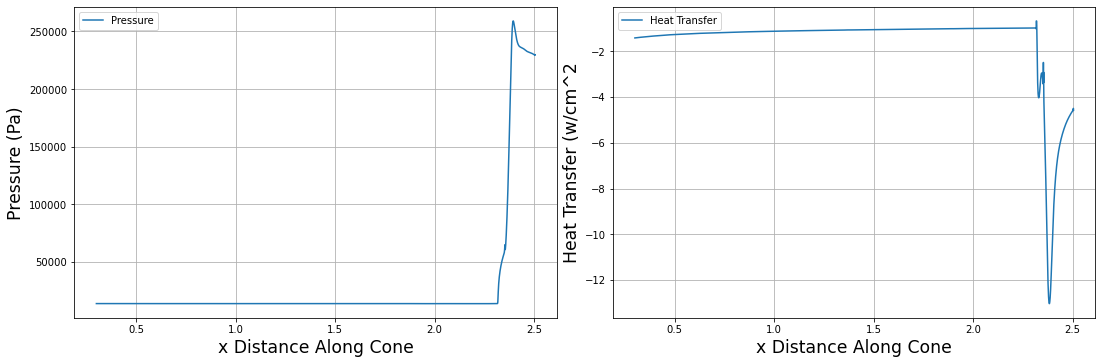

In [ ]:
p.shape

caseWePick = 147

plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=1.4, w_pad=2.5, h_pad=.5)
fig.patch.set_facecolor('white')

axs[0].plot(x_cc_sorted[caseWePick,idxWindowStart:], p[caseWePick,:], label = 'Pressure')
axs[1].plot(x_cc_sorted[caseWePick,idxWindowStart:], qw[caseWePick,:]/10000,label = 'Heat Transfer')

axs[0].set_ylabel("Pressure (Pa)")
axs[1].set_ylabel('Heat Transfer (w/cm^2')

axs[0].set_xlabel("x Distance Along Cone")
axs[1].set_xlabel("x Distance Along Cone")

axs[0].legend()
axs[1].legend()

### Input Data

A quick explanation of our models' output data 

qw = heat transfer at the wall

p = pressure at the wall

We won't be training the model using the x,y,z,tau,yplus, T, or the cell center locations. These will be used after the model is trained for analysis purposes. Note that the "T", or wall temperature value, was fixed by the CFD code as the thermal boundary condition. If you take a look inside the output T array, you'll find that it's all the same number as the input wall temperature. 

# Generate Low Fidelity Data - Shock Expansion, Eckert's Reference Temp


In [ ]:
M_inf[147]

array([6.10110613])

In [ ]:
## Input Conditions, low fidelity data generation

gamma = 1.4 # perfect gas
R_specific = 287.058
cp1 = 1.005 #KJ/Kg*K, air at 251K

T_inf = inputTemperature
T_w = inputWallTemp
rho_inf = inputDensity
u_inf = inputVelocity
a_inf = np.sqrt(gamma*R_specific*T_inf)
M_inf = u_inf/a_inf
P_inf = rho_inf*R_specific*T_inf
mu_inf = mu_suth(T_inf)

theta  = np.full((400,1),np.deg2rad(7))

inputDataObliqueShock = M_inf,u_inf,T_inf,P_inf,rho_inf,a_inf,theta

[*temp] = map(perfgas_oblique, M_inf,u_inf,T_inf,P_inf,rho_inf,a_inf,theta)
obliqueShockResults = np.array(temp)

outputLocalMethodVarName = [
    'H2', 
    'V2', 
    'T2', 
    'P2', 
    'rho2',
    'beta',
    'M2',
    'a2', 
    'T01', 
    'T02',
    'P01',
    'P02'
]

for i, name in enumerate(outputLocalMethodVarName):
    locals()[name] = obliqueShockResults[:,i]

In [ ]:
## ---- Pressure Coefficient ----

# Shock Expansion for 7deg Section

shockAngle = beta

cp_ShockExpansionTheory = (4/(gamma+1))*(np.sin(shockAngle)**2 - (1/(M_inf**2)))
cp_newtonian_coneAngle = 2*(np.sin(theta)**2)

xPressureWindowStart = 0.5
xPressureWindowEnd = 2.0
xPressureWindowMid = 0.5

xSpotBegin = (np.abs(x_cc_windowed[0,:] - xPressureWindowStart)).argmin()
xSpotEnd = (np.abs(x_cc_windowed[0,:] - xPressureWindowEnd)).argmin()
xSpotNoMean = (np.abs(x_cc_windowed[0,:] - xPressureWindowMid)).argmin()

PressureForCPActual = p[:,xSpotNoMean].reshape(-1,1)
cp_actual = (PressureForCPActual - P_inf)/ (0.5*rho_inf*(u_inf**2))
cp_actual[389] = None # takes care of that one bad point

#Shock Expansion For 40deg Section

T_inf2 = T2
T_w = inputWallTemp
rho_inf2 = rho2
u_inf2 = M2*a2
a_inf2 = a2
M_inf2 = M2
P_inf2 = P2
mu_inf2 = mu_suth(T2)
theta2  = np.full((400,1),np.deg2rad(33))

[*temp] = map(perfgas_oblique, M_inf2,u_inf2,T_inf2,P_inf2,rho_inf2,a_inf2,theta2)
obliqueShockResults = np.array(temp)

outputLocalMethodVarName = [
    'H3', 
    'V3', 
    'T3', 
    'P3', 
    'rho3',
    'beta2',
    'M3',
    'a3', 
    'T02', 
    'T03',
    'P02',
    'P03'
]

for i, name in enumerate(outputLocalMethodVarName):
    locals()[name] = obliqueShockResults[:,i]

In [ ]:
xPressureWindowLeft = 2.353056 # elbow location
xPressureWindowRight = 2.5039961 # end of cone

xPressureWindowMid = 2.4
xSpotLeft = (np.abs(x_cc_windowed[0,:] - xPressureWindowLeft)).argmin()
xSpotRight = (np.abs(x_cc_windowed[0,:] - xPressureWindowRight)).argmin()

meanPressure40DegConeSection = np.median(p[:,xSpotLeft:xSpotRight], axis = 1).reshape(-1,1)
cp_actual2 = (meanPressure40DegConeSection - P_inf2)/ (0.5*rho_inf2*(u_inf2**2))
cp_actual2[389] = None # takes care of that one bad case

cp_newtonian_coneAngle2 = 2*(np.sin(theta2)**2)
shockAngle2 = beta2
cp_ShockExpansionTheory2 = (4/(gamma+1))*(np.sin(shockAngle2)**2 - (1/(M_inf2**2)))

p_SE_7deg = cp_ShockExpansionTheory*(0.5*rho_inf*(u_inf**2)) + P_inf
p_Newtonian_40deg = cp_newtonian_coneAngle2*(0.5*rho_inf2*(u_inf2**2)) + P_inf2
p_SE_40deg = cp_ShockExpansionTheory2*(0.5*rho_inf2*(u_inf2**2)) + P_inf2

xSpotElbow = (np.abs(x_cc_windowed[0,:] - xPressureWindowLeft)).argmin()

p_lf_7deg = np.tile(p_SE_7deg, xSpotElbow+1)
p_lf_40deg_newt = np.tile(p_Newtonian_40deg, xSpotRight - xSpotLeft)
p_lf_40deg = np.tile(p_SE_40deg, xSpotRight - xSpotLeft)
p_lowFidelity_SE = np.concatenate((p_lf_7deg, p_lf_40deg), axis=1)
p_lowFidelity_Newt = np.concatenate((p_lf_7deg, p_lf_40deg_newt), axis=1)

p_lowFidelity_SE_truncated = np.concatenate((p_SE_7deg, p_SE_40deg), axis=1)
p_lowFidelity_SE_truncated = p_lowFidelity_SE_truncated.T

normalizedHFPressure = p/P03
normalizedLFPressure = p_lowFidelity_SE/P03
normalizedLFPressureNewt = p_lowFidelity_Newt/P03

## Plotting Pressure Coefficient Results

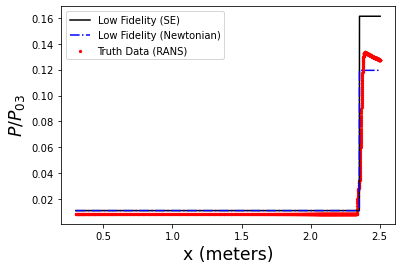

In [ ]:
caseWePick = random.randint(0,400)

plt.plot(x_cc_windowed[0,:],normalizedLFPressure[caseWePick,:], label = 'Low Fidelity (SE)', color = 'k')
plt.plot(x_cc_windowed[0,:],normalizedLFPressureNewt[caseWePick,:], label = 'Low Fidelity (Newtonian)', color = 'b', linestyle='-.')
plt.scatter(x_cc_sorted[caseWePick,idxWindowStart:], normalizedHFPressure[caseWePick,:],s=5, label = 'Truth Data (RANS)', color='r')
plt.legend()
# plt.title('Case Number ' + str(caseWePick))
plt.xlabel('x (meters)')
plt.ylabel('$P/P_{03}$')
plt.grid()

# plt.rcParams["figure.figsize"] = (5,5)
# plt.grid()
# plt.scatter(M_inf,cp_actual, label = 'RANS Truth CP', s=3)
# plt.scatter(M_inf,cp_ShockExpansionTheory, label = 'S-E Theory CP', s=3)
# plt.scatter(M_inf,cp_newtonian_coneAngle, label = 'Newtonian Theory CP', s=3)
# lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=20)
# plt.xlabel("Mach Number",fontsize='xx-large')
# plt.ylabel("Pressure Coefficient",fontsize='xx-large')
# plt.ylim([0,0.12])
# lgnd = plt.legend(loc='upper right', fontsize='x-large', markerscale = 5)
# # for i in range(0,7):
# #     lgnd.legendHandles[i]._sizes = [50]

# # TURN THIS INTO A SUBLPLOT, side by side

# plt.rcParams["figure.figsize"] = (7,5)
# plt.rcParams['figure.dpi'] = 300
# plt.grid()
# plt.scatter(M_inf,cp_actual2, label = 'RANS Truth CP', s=3)
# plt.scatter(M_inf,cp_ShockExpansionTheory2, label = 'S-E Theory CP', s=3)
# plt.scatter(M_inf,cp_newtonian_coneAngle2, label = 'Newtonian Theory CP', s=3)
# plt.scatter(M_inf,cp_actual, label = 'RANS Truth CP', s=3)
# plt.scatter(M_inf,cp_ShockExpansionTheory, label = 'S-E Theory CP', s=3)
# plt.scatter(M_inf,cp_newtonian_coneAngle, label = 'Newtonian Theory CP', s=3)
# lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=20)
# plt.rcParams['legend.facecolor'] = 'white'
# plt.xlabel("Mach Number",fontsize='xx-large')
# plt.ylabel("Pressure Coefficient",fontsize='xx-large')
# lgnd = plt.legend(loc='upper right', fontsize='x-large', markerscale = 5)

# Eckert's Reference Temperature

In [ ]:
## ---- Eckert's Reference Temperature, Cone Example ----

caseWePick = random.randint(0,399)
Pr = 0.72
recovFactor = np.sqrt(Pr)
xSpotEndArtificial = x_cc_windowed[0,:].shape[0] - xSpotElbow

x_FrontCone = x_cc_windowed[0,:xSpotElbow]
x_RearCone = x_cc_windowed[0,:xSpotEndArtificial] - 0.25

T_star = 0.5*(T2 + T_w) + .22*recovFactor*(T02 - T2)
rho_star = P2/ (R_specific*T_star)
mu_star = mu_suth(T2)
u2 = M2 * a2
Re_coeff = rho_star*u2/mu_star
Re_x = Re_coeff * x_FrontCone
cone_factor = np.sqrt(3)
cH_coeff = (cone_factor*0.332)/((Pr**(2/3))*(Re_coeff**(.5)))
cH_star = cH_coeff / x_FrontCone**(1/2)
T_r = T2 + recovFactor*(T02 - T2)
q_dot_FrontCone = rho_star*u2*cp1*1000*(T_r - T_w)*cH_star

T_star2 = 0.5*(T3 + T_w) + .22*recovFactor*(T03 - T3)
rho_star2 = P3/ (R_specific*T_star2)
mu_star2 = mu_suth(T3)
u3 = M3* a3
Re_coeff2 = rho_star2*u2/mu_star2
Re_x2 = Re_coeff2 * x_RearCone
cH_coeff2 = (cone_factor*0.332)/((Pr**(2/3))*(Re_coeff2**(.5)))
cH_star2 = cH_coeff2 / x_RearCone**(1/2)
T_r2 = T3 + recovFactor*(T03 - T3)
q_dot_RearCone = rho_star2*u3*cp1*1000*(T_r2 - T_w)*cH_star2

q_lowFidelity = np.concatenate((q_dot_FrontCone, q_dot_RearCone), axis=1)

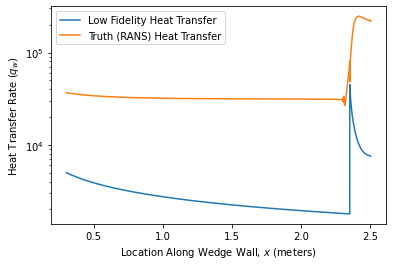

In [ ]:
plt.semilogy(x_cc_windowed[0,:],q_lowFidelity[caseWePick,:],label = 'Low Fidelity Heat Transfer')
plt.semilogy(x_cc_windowed[0,:],qw[caseWePick,:], label = 'Truth (RANS) Heat Transfer')
plt.grid()
plt.xlabel('Location Along Wedge Wall, $x$ (meters)')
plt.ylabel('Heat Transfer Rate ($q_w$)')
plt.legend()

# Low Fidelity Data Processing

### Data Scaling

In [ ]:
LFoutputVarNames = [
    'q_lowFidelity',
    'p_lowFidelity_SE',
]

inputTrainingData = []
inputTrainingNames = []

print('Input Data (stored in list inputTrainingData):\n')
for i, name in enumerate(inputVarNames):
    ScalerName = name + '_InputScaler'
    ScaledName = name + '_Scaled'
    InputDataName = 'input' + name
    locals()[ScalerName] = None
    locals()[ScalerName] = preprocessing.StandardScaler()
    locals()[ScaledName] = locals()[ScalerName].fit_transform(globals()[InputDataName])
    inputTrainingData.append(locals()[ScaledName])
    inputTrainingNames.append(ScaledName)
    max_element = str(round(np.max(locals()[ScaledName]),2))
    min_element = str(round(np.min(locals()[ScaledName]),2))
    print(name + ' has been scaled! It is called ' + ScaledName + '. Min:' + min_element + '. Max:' + max_element)

LFoutputTrainingData = []
LFoutputTrainingNames = []

print('\nOutput Data (stored in list LFoutputTrainingData):\n')
for i, name in enumerate(LFoutputVarNames):
    ScalerName = name + '_OutputScaler'
    ScaledName = name + '_Scaled'
    OutputDataName = name
    locals()[ScalerName] = None
    locals()[ScalerName] = preprocessing.StandardScaler()
    locals()[ScaledName] = locals()[ScalerName].fit_transform(globals()[OutputDataName])
    LFoutputTrainingData.append(locals()[ScaledName])
    LFoutputTrainingNames.append(ScaledName)
    max_element = str(round(np.max(locals()[ScaledName]),2))
    min_element = str(round(np.min(locals()[ScaledName]),2))
    print(name + ' has been scaled! It is called ' + ScaledName + '. Min:' + min_element + '. Max:' + max_element)

print(str(np.shape(inputTrainingData)))
print(str(np.shape(outputTrainingData)))
print(inputTrainingNames)
print(outputTrainingNames)

Input Data (stored in list inputTrainingData):

WallTemp has been scaled! It is called WallTemp_Scaled. Min:-1.73. Max:1.73
Density has been scaled! It is called Density_Scaled. Min:-1.73. Max:1.73
Temperature has been scaled! It is called Temperature_Scaled. Min:-1.73. Max:1.73
Velocity has been scaled! It is called Velocity_Scaled. Min:-1.73. Max:1.73

Output Data (stored in list LFoutputTrainingData):

q_lowFidelity has been scaled! It is called q_lowFidelity_Scaled. Min:-1.32. Max:3.69
p_lowFidelity_SE has been scaled! It is called p_lowFidelity_SE_Scaled. Min:-1.54. Max:3.89
(4, 400, 1)
(2, 400, 1284)
['WallTemp_Scaled', 'Density_Scaled', 'Temperature_Scaled', 'Velocity_Scaled']
['qw_Scaled', 'p_Scaled']


### Validation Split 

In [ ]:
# these values are already calculated in the low fidelity data generation section, but repeated here in the event that
# that section of the notebook has not been run yet. 

gamma = 1.4 # perfect gas
R_specific = 287.058

T_inf = inputTemperature
rho_inf = inputDensity
u_inf = inputVelocity
a_inf = np.sqrt(gamma*R_specific*T_inf)
M_inf = u_inf/a_inf

In [ ]:
##### SKLEARN DATA SPLIT 
random_state = 30 # used for reproducibility of data splits

X = np.hstack(inputTrainingData)
y_lf = np.hstack(LFoutputTrainingData)
Y_lf_names = np.hstack(LFoutputTrainingNames)
X_names = np.hstack(inputTrainingNames)

X_train, X_test, y_lf_train, y_lf_test = train_test_split(X, y_lf, test_size=0.20, random_state=random_state)
X_test, X_val, y_lf_test, y_lf_val = train_test_split(X_test, y_lf_test, test_size=0.50, random_state=random_state)
M_inf_train, M_inf_test = train_test_split(M_inf,test_size=0.20,random_state=random_state) # used in plotting
M_inf_test, M_inf_val = train_test_split(M_inf_test,test_size=0.50,random_state=random_state) # used in plotting

print("Low fidelity X_train shape: {}".format(X_train.shape))
print("Low fidelity X_test shape: {}".format(X_test.shape))
print("Low fidelity y_lf_train shape: {}".format(y_lf_train.shape))
print("Low fidelity y_lf_test shape: {}".format(y_lf_test.shape))
print("Low fidelity X_val shape: {}".format(X_val.shape))
print("Low fidelity y_lf_val shape: {}".format(y_lf_val.shape))
print(f"concatenation order: {X_names}")
print(f"concatenation order: {Y_lf_names}")

Low fidelity X_train shape: (320, 4)
Low fidelity X_test shape: (40, 4)
Low fidelity y_lf_train shape: (320, 2568)
Low fidelity y_lf_test shape: (40, 2568)
Low fidelity X_val shape: (40, 4)
Low fidelity y_lf_val shape: (40, 2568)
concatenation order: ['WallTemp_Scaled' 'Density_Scaled' 'Temperature_Scaled' 'Velocity_Scaled']
concatenation order: ['q_lowFidelity_Scaled' 'p_lowFidelity_SE_Scaled']


# LF Kriging

In [ ]:
# Kernel options include: Compound, Constant, Dot Product, Exponentiation, ExpSineSquared, 
# Product, Rational Quadratic, RBF, Sum, White

# Benchmark Function 1
kernel1 = ConstantKernel(1.0, (1e-8, 1e2)) * RBF(1.0, (1e-8, 1e2)) # Works great for Benchmark Function 1

#Benchmark Function 2
kernel2 = 66.3*RBF(0.1, (1e-8, 1e2)) #seems to work well for discontinuities, so we'll try for Benchmark Function 2

#Benchmark Function 3
kernel3 = kernel2

# Below are the different kernels (and combinations of kernels) that Dr. Reasor used in his code

#kernel = ConstantKernel(1.0) + Matern(length_scale=0.1, nu=3/2) #+ WhiteKernel(noise_level=1)
#kernel = 1.0*Matern(length_scale=0.1, nu=1.5)
#kernel = RationalQuadratic()
#kernel = Matern(length_scale=0.1, nu=2.5)  #
#kernel = ConstantKernel(1.0, (1e-8, 1e2)) * RBF(0.1, (1e-8, 1e2))
#kernel = Cdatetime.dateonstantKernel(1.0, (1e-3, 1e3))*RBF(1.0, (1e-2, 1e2))

In [ ]:
LFKrigLoad = False
LFKrigTrain = True
LFKrigSave = True

## Train LF Kriging

In [ ]:
if LFKrigTrain: 
    LF_krig = None
    LF_krig = gaussian_process.GaussianProcessRegressor(kernel=kernel2,n_restarts_optimizer=1)
    LF_krig.fit(X_train, y_lf_train)

## Save LF Kriging

In [ ]:
if LFKrigSave:
    path = "/home/tyty/Desktop/CFD_Files/MFmodelTestData"
    os.chdir(path)

    model = LF_krig
    filename = 'LF_krig_'
    dt = str(datetime.date.today())
    ext = '.sav'
    filename += dt + ext
    pickle.dump(model, open(filename, 'wb'))

## Load LF Kriging

In [ ]:
if LFKrigLoad:
    path = "/home/tyty/Desktop/CFD_Files/MFmodelTestData"
    os.chdir(path)

    filename = 'LF_krig_2022-03-20.sav'
    desiredLoadedModelName = 'LF_krig_loaded'

    locals()[desiredLoadedModelName] = pickle.load(open(filename, 'rb'))
    
    LF_krig = None
    LF_krig = LF_krig_loaded

## Generate Predictions

In [ ]:
# Generate Predicitions
numCases = len(X[:,0])

start = time.time()
LF_krig_train_prediction = LF_krig.predict(X_train)
LF_krig_test_prediction = LF_krig.predict(X_test)
end = time.time()
print('Prediction time per case: %0.7f seconds, %0.3f Hz ' % (((end-start)/numCases), 1/((end-start)/numCases)) )

Prediction time per case: 0.0000521 seconds, 19193.045 Hz 


# Start up again here. 
Need to fix the scaling block, probably also rename the LF data. 

In [ ]:
LFoutputVarNames

['q_lowFidelity', 'p_lowFidelity_SE']

In [ ]:
# Split prediction array into heat transfer and pressure distributions
[qw_LF_krig_train_predict, p_LF_krig_train_predict] = np.hsplit(LF_krig_train_prediction, 2)
[qw_LF_krig_test_predict, p_LF_krig_test_predict] = np.hsplit(LF_krig_test_prediction, 2)

[qw_LF_train_truth, p_LF_train_truth] = np.hsplit(y_lf_train, 2)
[qw_LF_test_truth, p_LF_test_truth] = np.hsplit(y_lf_test, 2)

# q_lowFidelity has been scaled! It is called q_lowFidelity_Scaled. Min:-1.32. Max:3.69
# p_lowFidelity_SE has been scaled! It is called p_lowFidelity_SE_Scaled. Min:-1.54. Max:3.89
# (4, 400, 1)
# (2, 400, 1284)
# ['WallTemp_Scaled', 'Density_Scaled', 'Temperature_Scaled', 'Velocity_Scaled']
# ['qw_Scaled', 'p_Scaled']

dataSplitNames = [
    '_LF_krig_test_predict',
    '_LF_krig_train_predict',
    '_LF_test_truth',
    '_LF_train_truth',
]

for name in LFoutputVarNames:
    ScalerName = name + '_OutputScaler'
    for tail in dataSplitNames:
        fullName = name + tail
        locals()[fullName] = locals()[ScalerName].inverse_transform(locals()[fullName])
        print(fullName + ' has been inverse transformed! It is called ' + fullName)

KeyError: 'q_lowFidelity_LF_krig_test_predict'

In [ ]:
#Now we'll need to un-concatenate and scale the output predictions
outputDataSplit = int(LFoutputDataConcat.shape[1]/len(LFoutputVarNames))
indexStart = 0
indexEnd = outputDataSplit

outputPredictedData = []

for i, name in enumerate(LFoutputVarNames):
    OutputDataName = name + '_predicted'
    locals()[OutputDataName] = LF_krig_prediction[:,indexStart:indexEnd]
    indexStart += outputDataSplit
    indexEnd += outputDataSplit
    
    ScalerName = name + '_OutputScaler'
    locals()[OutputDataName] = locals()[ScalerName].inverse_transform(globals()[OutputDataName])
    outputPredictedData.append(locals()[ScaledName])
    max_element = str(round(np.max(locals()[OutputDataName]),2))
    min_element = str(round(np.min(locals()[OutputDataName]),2))
    print(OutputDataName + ' has been inverse transformed! It is called ' + OutputDataName + 
          '. Min:' + min_element + '. Max:' + max_element)

q_lowFidelity_predicted has been inverse transformed! It is called q_lowFidelity_predicted. Min:-21456.97. Max:2252965.58
p_lowFidelity_SE_predicted has been inverse transformed! It is called p_lowFidelity_SE_predicted. Min:1365.36. Max:1719525.06


In [ ]:
## Plotting Kriging predictions vs. actual low fidelity data

# desiredNumCasesForPlot = 15
# casePlotRange= np.arange(0,400,int((400/desiredNumCasesForPlot)))

# plt.rcParams["figure.figsize"] = (10,5)
# fig, axs = plt.subplots(1, 2)
# fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)
# fig.patch.set_facecolor('white')

  
# for i, case in enumerate(casePlotRange):
#     labelstr = 'Case: ' + str(case)
#     axs[0].scatter(q_lowFidelity_predicted[case,:],q_lowFidelity[case,:], s=1, label = labelstr )
#     axs[1].scatter(p_lowFidelity_SE_predicted[case,:],p_lowFidelity_SE[case,:], s=1, label = labelstr)


    
# # axs[0].scatter(qw_predicted[389,:],qw[389,:], s=1, label = 'Case 389' )
# # axs[1].scatter(p_predicted[389,:],p[389,:], s=1)

# axs[0].set_title("Kriging Heat Transfer Predicitions vs Actual")
# axs[1].set_title("Kriging Pressure Predictions vs. Actual")
# axs[0].grid()
# axs[1].grid()
# axs[0].set_ylabel("True Value")
# axs[0].set_xlabel("Predicted Heat Transfer")
# axs[1].set_xlabel("Predicted Pressure")

# # for i in range(0,2):
# # axs[0].legend().legendHandles[0]._sizes = [100]


# # fig.savefig('Krig_predict.png', bbox_inches='tight')

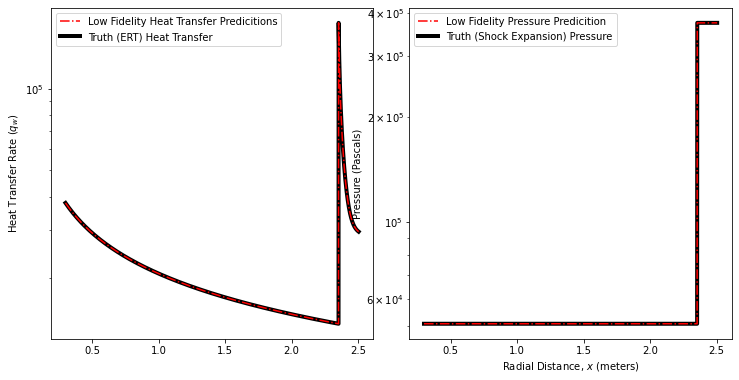

In [ ]:
caseWePick = random.randint(0,399)

plt.rcParams["figure.figsize"] = (10,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)
fig.patch.set_facecolor('white')

axs[0].semilogy(x_cc_windowed[0,:],q_lowFidelity_predicted[caseWePick,:],
                label = 'Low Fidelity Heat Transfer Predicitions', linestyle = '-.', color = 'red', zorder=3)
axs[0].semilogy(x_cc_windowed[0,:],q_lowFidelity[caseWePick,:],
                label = 'Truth (ERT) Heat Transfer',color='black', linestyle='solid',
                linewidth=4)
axs[0].grid()

axs[1].semilogy(x_cc_windowed[0,:],p_lowFidelity_SE_predicted[caseWePick,:],
                label = 'Low Fidelity Pressure Predicition', linestyle = '-.', color = 'red',zorder=3)
axs[1].semilogy(x_cc_windowed[0,:],p_lowFidelity_SE[caseWePick,:], 
                label = 'Truth (Shock Expansion) Pressure',color='black', linestyle='solid',
                linewidth=4)

axs[1].grid()
# xlim([min(x)-.1 max(x)+.1])
axs[1].set_xlabel('Radial Distance, $x$ (meters)')
axs[0].set_ylabel('Heat Transfer Rate ($q_w$)')

axs[1].set_xlabel('Radial Distance, $x$ (meters)')
axs[1].set_ylabel('Pressure (Pascals)')

axs[0].legend()
axs[1].legend()

# Low Fidelity Neural Network 

In [ ]:
#Would you like to train a new model? 
trainNN = False

#Would you like to save your model? 
saveNN, saveHistoryandEpochs = False , False

#Would you like to load a previously trained model ?
loadNN, loadHistoryandEpochs = True, True

#If you have trained a model in this same workspace as well as loaded a model, would you like to overwrite with your loaded model? 
#If you have not trained a model, but loaded a model, then leave this "True"
if not trainNN and loadNN: 
    overwrite = True
    
#Initialize hyperparamters for Single Fidelity Model
if trainNN: 
    layer1size = 32 
    layer2size = 64
    numOutputData = 2
    rate = 1.0e-3 #From Deep Learning w/ Python (Chollet)
    # rate = 5.0e-2 # used by Dr. Reasor
    reg = 1.0e-6
    numEpochs = 1000
    myBatchSize = None
    validSplit = None

In [ ]:
if trainNN: 

    numCases = str(len(WallTemp_Scaled[:,0]))
    inputArraySize = str(WallTemp_Scaled.shape)
    outputArraySize = str(q_lowFidelity_Scaled.shape)
    numInput = str(len(inputVarNames))
    numOutput = str(len(LFoutputVarNames))
    singleOutput = str(len(q_lowFidelity_Scaled[0,:]))

    print('We are using %s cases. Meaning each input array is %s, each output array is %s \n' % 
          (numCases, inputArraySize, outputArraySize))
    print('Note: The network, as depicted below, will take data from one case at a time. Therefore,'
         'the input data will be %s 1x1 arrays, and the output will be %s 1x%s arrays \n \n \n' % 
          (numInput, numOutput, singleOutput ))
    LF_NN = None #sometimes remnants of previously trained models can hang around, it's best 
                 #to clear the variable first 
    LF_NN = build_model_single_fidelity(WallTemp_Scaled, q_lowFidelity_Scaled, numOutputData, 
                                        layer1size, layer2size, rate, reg)
    tf.keras.utils.plot_model(LF_NN,show_shapes=True)

In [ ]:
if trainNN:

    LF_NN_epochs = None
    LF_NN_history = None

    LF_NN_epochs, LF_NN_history = train_model_all_fidelity(
        LF_NN, inputTrainingData, outputTrainingData, numEpochs, myBatchSize, validSplit)

In [ ]:
if saveNN:

    # The try/except syntax catches the error if we've already created the directory. 
    path = "/home/tyty/Desktop/CFD_Files/MFmodelTestData"
    kerasFolderName = 'LF_NN_'
    dt = str(datetime.date.today())
    kerasFolderName += dt

    try: 
        os.chdir(path)
        mkdirPath = os.path.join(path, kerasFolderName)
        os.mkdir(mkdirPath)
    except: 
        pass 

    # We won't be saving the NN in the same way that we save the GP model. Keras likes to save all kind of other stuff, with no intuitive way to change the file names.
    # For version control purposes (really, to make sure we're not overwriting old models), we'll create a new folder for each saved model with the date included. 

    path = "/home/tyty/Desktop/CFD_Files/MFmodelTestData"
    path += '/' + kerasFolderName
    os.chdir(path)

    model = LF_NN
    model.save(path)
    
if saveHistoryandEpochs:
    epochsDict = LF_NN_epochs
    historyDict = LF_NN_history

    epochsFilename = 'LF_NN_epochs'
    historyFilename = 'LF_NN_history'
    dt = str(datetime.date.today())
    ext = '.pkl'
    epochsFilename += '_' + dt + ext
    historyFilename += '_' + dt + ext
    pickle.dump(epochsDict, open(epochsFilename, 'wb'))
    pickle.dump(historyDict, open(historyFilename, 'wb'))

## Load LF NN

In [ ]:
if loadNN: 
    # Loading the NN is a bit easier-- but you'll need to specify the path. An example path is included already, which will need to be edited if you wish to load a different model. 
    path = '/home/tyty/Desktop/CFD_Files/MFmodelTestData/LF_NN_2022-03-20'
    os.chdir(path)
    loadedModelName = 'LF_NN'

    locals()[loadedModelName] = keras.models.load_model(path)

### Load History and Epochs

if loadHistoryandEpochs:
    # some time later... load the model from disk

    # path variable should already be defined from when you loaded the NN model. If not, uncomment the 2 lines below. 
    # path = '/home/tyty/Desktop/CFD_Files/MFmodelTestData/HF_NN_2022-02-11'
    # os.chdir(path)

    epochsFilename = 'LF_NN_epochs_2022-03-20.pkl'
    historyFilename = 'LF_NN_history_2022-03-20.pkl'

    desiredLoadedEpochsName = 'LF_NN_epochs'
    desiredLoadedHistoryName = 'LF_NN_history'

    locals()[desiredLoadedEpochsName] = pickle.load(open(epochsFilename, 'rb'))
    locals()[desiredLoadedHistoryName] = pickle.load(open(historyFilename, 'rb'))

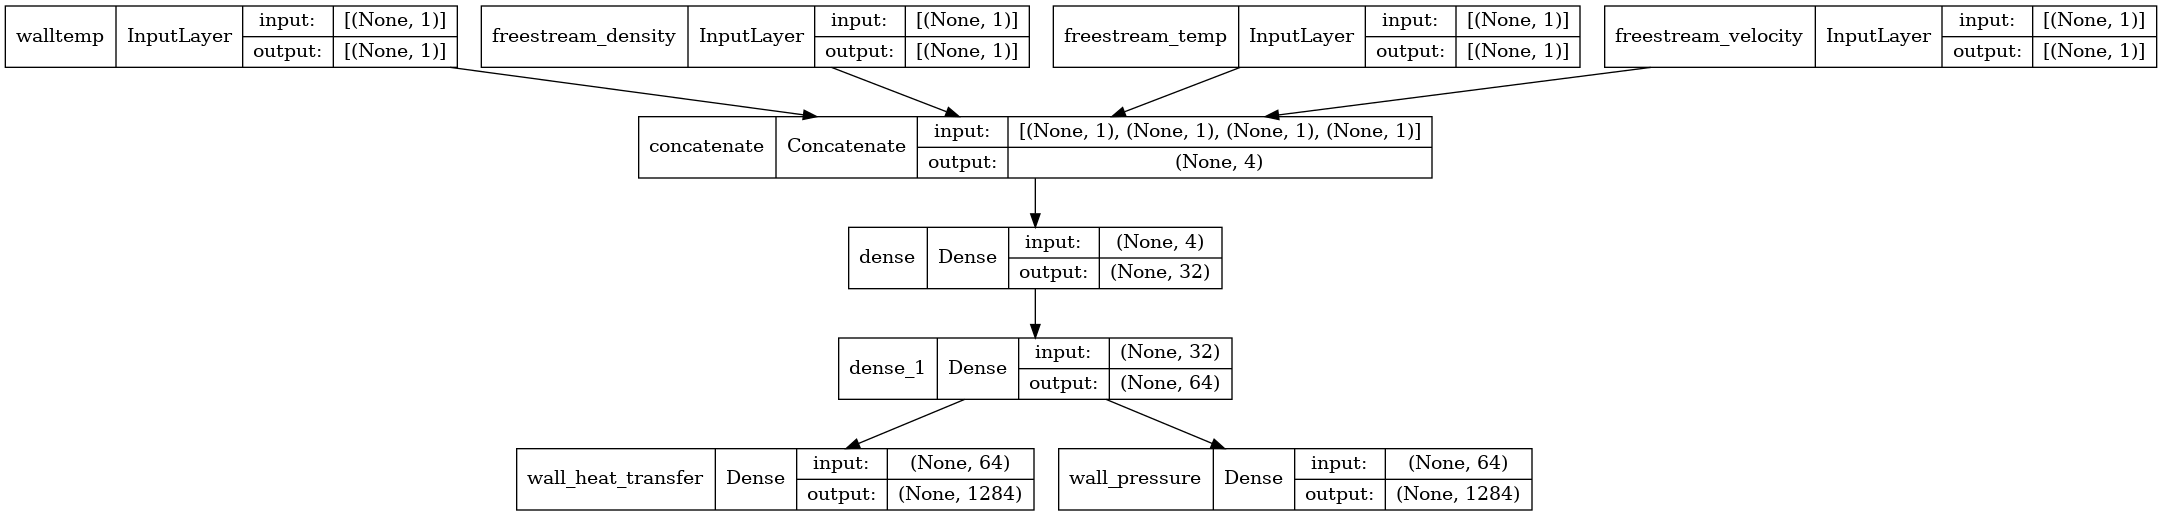

In [ ]:
tf.keras.utils.plot_model(LF_NN,show_shapes=True)

## Plot Training MSE for LF NN

Mean Squared Error 2.5260331 percent


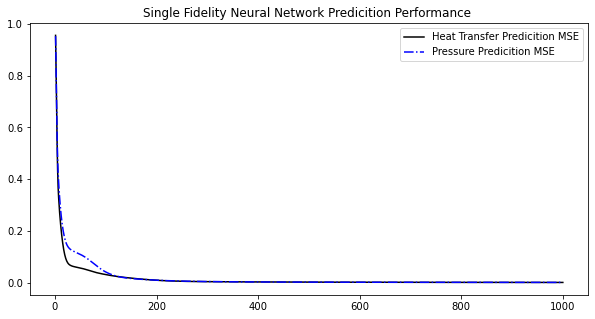

In [ ]:
mse_history_qw = LF_NN_history["wall_heat_transfer_mean_squared_error"]
mse_history_P = LF_NN_history["wall_pressure_mean_squared_error"]

# Input the desired epoch range

epochRangeBegin = 0 
epochRangeEnd = 5000

plt.plot(range(1,len(mse_history_qw[epochRangeBegin:epochRangeEnd]) + 1),
         mse_history_qw[epochRangeBegin:epochRangeEnd],
         label="Heat Transfer Predicition MSE",linestyle="-", color="k")
plt.plot(range(1,len(mse_history_P[epochRangeBegin:epochRangeEnd]) + 1),
         mse_history_P[epochRangeBegin:epochRangeEnd],
         label="Pressure Predicition MSE",linestyle="-.", color="b")
plt.title("Single Fidelity Neural Network Predicition Performance ")
plt.legend(loc=0)
plt.grid()

minError = np.min(LF_NN_history["wall_heat_transfer_mean_squared_error"])
MSE = np.sqrt(minError)
print('Mean Squared Error %0.7f percent' % (MSE*100, ))

## LF NN Predictions

In [ ]:
[q_lowFidelity_predicted, p_lowFidelity_SE_predicted] = LF_NN.predict(inputTrainingData)


outputPredictedData = []

print('\nPredicted Output Data (stored in list outputPredictedData):\n')
for i, name in enumerate(LFoutputVarNames):
    ScalerName = name + '_OutputScaler'
    OutputDataName = name + '_predicted'
    locals()[OutputDataName] = locals()[ScalerName].inverse_transform(globals()[OutputDataName])
    outputPredictedData.append(locals()[ScaledName])
    max_element = str(round(np.max(locals()[OutputDataName]),2))
    min_element = str(round(np.min(locals()[OutputDataName]),2))
    print(OutputDataName + ' has been inverse transformed! It is called ' +
          OutputDataName + '. Min:' + min_element + '. Max:' + max_element)


Predicted Output Data (stored in list outputPredictedData):

q_lowFidelity_predicted has been inverse transformed! It is called q_lowFidelity_predicted. Min:-15042.44. Max:2229792.0
p_lowFidelity_SE_predicted has been inverse transformed! It is called p_lowFidelity_SE_predicted. Min:1730.36. Max:1717267.5


Text(0.5, 24.0, 'Predicted Pressure')

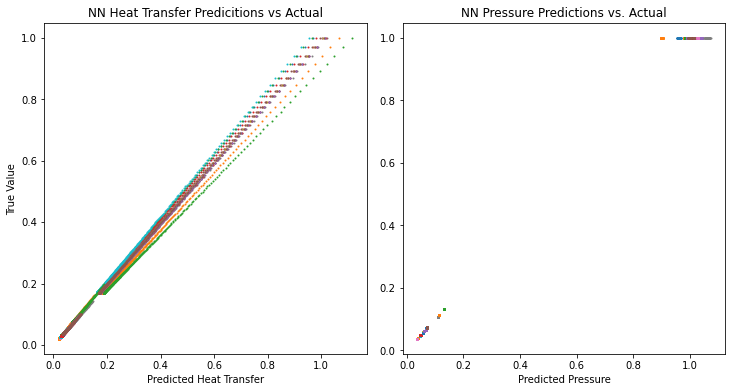

In [ ]:
desiredNumCasesForPlot = 15
casePlotRange= np.arange(0,400,int((400/desiredNumCasesForPlot)))

plt.rcParams["figure.figsize"] = (10,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)
fig.patch.set_facecolor('white')

for i, case in enumerate(casePlotRange):
    labelstr = 'Case: ' + str(case)
    maxHeatTransfer = q_lowFidelity[case,:].max()
    maxPressure = p_lowFidelity_SE[case,:].max()
    axs[0].scatter(q_lowFidelity_predicted[case,:]/maxHeatTransfer,q_lowFidelity[case,:]/maxHeatTransfer, s=1, label = labelstr )
    axs[1].scatter(p_lowFidelity_SE_predicted[case,:]/maxPressure,p_lowFidelity_SE[case,:]/maxPressure, s=1, label = labelstr)

    
# axs[0].scatter(qw_predicted[389,:],qw[389,:], s=1, label = 'Case 389' )
# axs[1].scatter(p_predicted[389,:],p[389,:], s=1)

axs[0].set_title("NN Heat Transfer Predicitions vs Actual")
axs[1].set_title("NN Pressure Predictions vs. Actual")
axs[0].grid()
axs[1].grid()
axs[0].set_ylabel("True Value")
axs[0].set_xlabel("Predicted Heat Transfer")
axs[1].set_xlabel("Predicted Pressure")

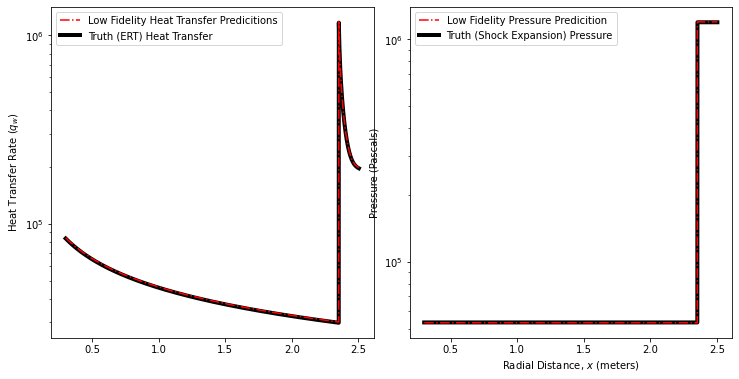

In [ ]:
caseWePick = random.randint(0,399)

plt.rcParams["figure.figsize"] = (10,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)
fig.patch.set_facecolor('white')

axs[0].semilogy(x_cc_windowed[0,:],q_lowFidelity_predicted[caseWePick,:],
                label = 'Low Fidelity Heat Transfer Predicitions', linestyle = '-.', color = 'red', zorder=3)
axs[0].semilogy(x_cc_windowed[0,:],q_lowFidelity[caseWePick,:],
                label = 'Truth (ERT) Heat Transfer',color='black', linestyle='solid',
                linewidth=4)
axs[0].grid()

axs[1].semilogy(x_cc_windowed[0,:],p_lowFidelity_SE_predicted[caseWePick,:],
                label = 'Low Fidelity Pressure Predicition', linestyle = '-.', color = 'red',zorder=3)
axs[1].semilogy(x_cc_windowed[0,:],p_lowFidelity_SE[caseWePick,:], 
                label = 'Truth (Shock Expansion) Pressure',color='black', linestyle='solid',
                linewidth=4)


axs[1].grid()
# xlim([min(x)-.1 max(x)+.1])
axs[1].set_xlabel('Radial Distance, $x$ (meters)')
axs[0].set_ylabel('Heat Transfer Rate ($q_w$)')

axs[1].set_xlabel('Radial Distance, $x$ (meters)')
axs[1].set_ylabel('Pressure (Pascals)')

axs[0].legend()
axs[1].legend()

#################################################################

## Similar code but with nicer plots (maybe?)

# case = 286 #Select the run that you would like to plot
# sliceVal = 25 # this is the "ol' fashioned way" for the plt.plot argument "markevery=sliceVal." The command doesn't work in plt.scatter
# xUpperLimit = 2.55
# xLowerLimit = None

# # inputWallTemp, inputDensity , inputTemperature , inputVelocity 
# # q_lowFidelity, p_lowFidelity_SE
    
# textstr = '\n'.join((
#     'Wall Temp: ' + str(round(inputWallTemp[case].item(), 2)) + ' K',
#     'Freestream Temp: ' + str(round(inputTemperature[case].item(), 2)) + ' K',
#     'Freestream Density: ' + str(round(inputDensity[case].item(), 2)) + ' kg/m3',
#     'Freestream Velocity: ' + str(round(inputVelocity[case].item(), 2)) + ' m/s'
#     ))
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# plt.rcParams["figure.figsize"] = (15,3.5)
# fig, axs = plt.subplots(1, 2)
# fig.tight_layout(pad=0.4, w_pad=2.0, h_pad=1.5)
# fig.patch.set_facecolor('white')

# # plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
# axs[0].plot(x_cc_sorted[0,idxWindowStart:], q_lowFidelity[case,:]/10000, color='firebrick', linestyle='solid', linewidth=4, label='RANS CFD Output (Truth Data)')
# axs[0].scatter(x_cc_sorted[0,idxWindowStart::sliceVal], q_lowFidelity_predicted[case,::sliceVal]/10000, c='white',
#                zorder=3,edgecolors='black', marker='D', s=70, label='Neural Network Predicition')
# # axs[0].set_title("Predicted Heat Transfer, Single Fidelity Only",fontsize='x-large')
# axs[0].set_ylabel("Heat Transfer (W/cm^2)", fontsize='x-large')

# # plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
# axs[1].plot(x_cc_sorted[0,idxWindowStart:], p_lowFidelity_SE[case,:]*1e-3, color='black', linestyle='solid', linewidth=4, label='RANS CFD Output (Truth Data)')
# axs[1].scatter(x_cc_sorted[0,idxWindowStart::sliceVal], p_lowFidelity_SE_predicted[case,::sliceVal]*1e-3, c='white',
#                zorder=3,edgecolors='black', marker='D', s=70, label='Neural Network Predicition')
# axs[1].set_title("Predicted Pressure", fontsize='x-large')
# axs[1].set_ylabel("Pressure (kPa)", fontsize='x-large')

# for i in np.arange(0,len(axs)):
#     # axs[i].grid()
#     # axs[i].legend().get_frame().set_edgecolor('b')
#     # axs[i].legend().get_frame().set_linewidth(10)
#     axs[i].legend(fontsize='x-large', edgecolor='k')
#     axs[i].set_xlabel('x-distance Along Cone (meters)',fontsize='x-large')
#     axs[i].set_xlim([xLowerLimit,xUpperLimit])
#     # axs[i].text(0.05, 0.55, textstr, transform=axs[i].transAxes, fontsize=14,
#     #     verticalalignment='top', bbox=props)

# High Fidelity Data Processing 

## Data scaling
using sklearn's ```Standard.Scaler```

In order to model effectively, we'll want to scale our training data appropriately. In this case, we're using sklearn's ```preprocessing.StandardScaler()```. The module standardizes features by removing the mean and scaling to unit variance. The standard score of a sample x is calculated as: ```z = (x - u) / s```, where ```u``` is the mean of the training samples or zero if ```with_mean=False```, and ```s``` is the standard deviation of the training samples or one if ```with_std=False```.

This is included in the comments of the below code block, but keep in my that each data set needs its own distinct scaler object. If you don't create a scaler object for each data set, you won't be able to inverse transform the data properly. 

The code in the next cell looks ugly, but it is a more robust way to do what the code directly below this sentence is doing. First, we make sure our new variable is not pointing to a Scaler object with the "None." Then, we assign the variable a Scaler object. Lastly, we create a new np.array with our scaled dating using the ".fit_transform" function. 

ScalerName = None

ScalerName = preprocessing.StandardScaler()

ScaledData = ScalerName.fit_transform(original_data)

## Validation Split
Validation Split: ```sklearn.model_selection.train_test_split```

[scikit-learn: train test split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [ ]:
inputTrainingData = []
inputTrainingNames = []

print('Input Data (stored in list inputTrainingData):\n')
for i, name in enumerate(inputVarNames):
    ScalerName = name + '_InputScaler'
    ScaledName = name + '_Scaled'
    InputDataName = 'input' + name
    locals()[ScalerName] = None
    locals()[ScalerName] = preprocessing.StandardScaler()
    locals()[ScaledName] = locals()[ScalerName].fit_transform(globals()[InputDataName])
    inputTrainingData.append(locals()[ScaledName])
    inputTrainingNames.append(ScaledName)
    max_element = str(round(np.max(locals()[ScaledName]),2))
    min_element = str(round(np.min(locals()[ScaledName]),2))
    print(name + ' has been scaled! It is called ' + ScaledName + '. Min:' + min_element + '. Max:' + max_element)

outputTrainingData = []
outputTrainingNames = []

print('\nOutput Data (stored in list outputTrainingData):\n')
for i, name in enumerate(outputVarNames):
    ScalerName = name + '_OutputScaler'
    ScaledName = name + '_Scaled'
    OutputDataName = name
    locals()[ScalerName] = None
    locals()[ScalerName] = preprocessing.StandardScaler()
    locals()[ScaledName] = locals()[ScalerName].fit_transform(globals()[OutputDataName])
    outputTrainingData.append(locals()[ScaledName])
    outputTrainingNames.append(ScaledName)
    max_element = str(round(np.max(locals()[ScaledName]),2))
    min_element = str(round(np.min(locals()[ScaledName]),2))
    print(name + ' has been scaled! It is called ' + ScaledName + '. Min:' + min_element + '. Max:' + max_element)

print(str(np.shape(inputTrainingData)))
print(str(np.shape(outputTrainingData)))
print(inputTrainingNames)
print(outputTrainingNames)

Input Data (stored in list inputTrainingData):

WallTemp has been scaled! It is called WallTemp_Scaled. Min:-1.73. Max:1.73
Density has been scaled! It is called Density_Scaled. Min:-1.73. Max:1.73
Temperature has been scaled! It is called Temperature_Scaled. Min:-1.73. Max:1.73
Velocity has been scaled! It is called Velocity_Scaled. Min:-1.73. Max:1.73

Output Data (stored in list outputTrainingData):

qw has been scaled! It is called qw_Scaled. Min:-1.59. Max:4.86
p has been scaled! It is called p_Scaled. Min:-1.6. Max:4.86
(4, 400, 1)
(2, 400, 1284)
['WallTemp_Scaled', 'Density_Scaled', 'Temperature_Scaled', 'Velocity_Scaled']
['qw_Scaled', 'p_Scaled']


In [ ]:
# these values are already calculated in the low fidelity data generation section, but repeated here in the event that
# that section of the notebook has not been run yet. 

gamma = 1.4 # perfect gas
R_specific = 287.058

T_inf = inputTemperature
rho_inf = inputDensity
u_inf = inputVelocity
a_inf = np.sqrt(gamma*R_specific*T_inf)
M_inf = u_inf/a_inf

In [ ]:
originalIdx = np.arange(0,400)

In [ ]:
##### SKLEARN DATA SPLIT 
random_state = 30 # used for reproducibility of data splits

X = np.hstack(inputTrainingData)
y = np.hstack(outputTrainingData)
Y_names = np.hstack(outputTrainingNames)
X_names = np.hstack(inputTrainingNames)
originalIdx = np.arange(0,400)

X_train, X_test, y_train, y_test, M_inf_train, M_inf_test, trainIdx, testIdx = train_test_split(
    X, y, M_inf, originalIdx, test_size=0.20, random_state=random_state)

X_test, X_val, y_test, y_val, M_inf_test, M_inf_val, testIdx, valIdx = train_test_split(
    X_test, y_test, M_inf_test, testIdx, test_size=0.50, random_state=random_state)
# M_inf_train, M_inf_test = train_test_split(M_inf,test_size=0.20,random_state=random_state) # used in plotting
# M_inf_test, M_inf_val = train_test_split(M_inf_test,test_size=0.50,random_state=random_state) # used in plotting

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))
print(f"concatenation order: {X_names}")
print(f"concatenation order: {Y_names}")

X_train shape: (320, 4)
X_test shape: (40, 4)
y_train shape: (320, 2568)
y_test shape: (40, 2568)
X_val shape: (40, 4)
y_val shape: (40, 2568)
concatenation order: ['WallTemp_Scaled' 'Density_Scaled' 'Temperature_Scaled' 'Velocity_Scaled']
concatenation order: ['qw_Scaled' 'p_Scaled']


# Kriging (Gaussian Process, or GP)

In [ ]:
# What would you like to do? Load an old model? Train and save a new model?

HFKrigLoad = False
HFKrigTrain = True
HFKrigSave = True

## Gaussian Process Kernels
What kernels do/how to select kernels:

[The Kernel Cookbook: Advice on Covariance functions](https://www.cs.toronto.edu/~duvenaud/cookbook/)


In [ ]:
kernel2 = 66.3*RBF(0.1, (1e-8, 1e2)) #seems to work well for discontinuities on the analytical functions
kernel = 1.0*Matern(length_scale=0.1, nu=1.5)

# Below are the different kernels (and combinations of kernels) that Dr. Reasor used in his code

#kernel = ConstantKernel(1.0) + Matern(length_scale=0.1, nu=3/2) #+ WhiteKernel(noise_level=1)
#kernel = 1.0*Matern(length_scale=0.1, nu=1.5)
#kernel = RationalQuadratic()
#kernel = Matern(length_scale=0.1, nu=2.5)  #
#kernel = ConstantKernel(1.0, (1e-8, 1e2)) * RBF(0.1, (1e-8, 1e2))
#kernel = Cdatetime.dateonstantKernel(1.0, (1e-3, 1e3))*RBF(1.0, (1e-2, 1e2))

## Gaussian Process (using sklearn's gaussian_process)

*Building our multi-fidelity kriging the ol' fashioned way* 

This module provides the user control over the hyperparameters (specifically the kernels, n restarts optimizer), but is a bit more abstract that GPy, which is why it was chosen over other GP modules (like GPy). 

kernel: class-kernel instance, default=None
The kernel specifying the covariance function of the GP. If None is passed, the kernel ConstantKernel(1.0, constant_value_bounds="fixed" * RBF(1.0, length_scale_bounds="fixed") is used as default. Note that the kernel hyperparameters are optimized during fitting unless the bounds are marked as “fixed”.

n_restarts_optimizer: class-int, default=0
The number of restarts of the optimizer for finding the kernel’s parameters which maximize the log-marginal likelihood. The first run of the optimizer is performed from the kernel’s initial parameters, the remaining ones (if any) from thetas sampled log-uniform randomly from the space of allowed theta-values. If greater than 0, all bounds must be finite. Note that n_restarts_optimizer == 0 implies that one run is performed.

$\textit{Some words about multi-output Kriging} $

Multi-input, multi-output Kriging

"At the heart of your issue lies something rarely mentioned (or even hinted at) in practice and in relevant tutorials: Gaussian Process regression with multiple outputs is highly non-trivial and still a field of active research. Arguably, scikit-learn cannot really handle the case, despite the fact that it will superficially appear to do so, without issuing at least some relevant warning."

https://stackoverflow.com/questions/50185399/multiple-output-gaussian-process-regression-in-scikit-learn

## Building the GP Model and Fitting the Data

In [ ]:
if HFKrigTrain:
    HF_krig = None
    HF_krig = gaussian_process.GaussianProcessRegressor(kernel=kernel2,n_restarts_optimizer=1)
    HF_krig.fit(X_train,y_train)

## Saving or loading your models

The larger your data gets, and the longer the train time gets, the more you may be interested in saving/loading a pre-trained model. 

In [ ]:
## Saving your model
if HFKrigSave:
    path = "/home/tyty/Desktop/CFD_Files/MFmodelTestData"
    os.chdir(path)

    model = HF_krig
    filename = 'HF_krig_'
    dt = str(datetime.date.today())
    ext = '.sav'
    filename += dt + ext
    pickle.dump(model, open(filename, 'wb'))

In [ ]:
# some time later... load the model from disk
if HFKrigLoad:
    path = "/home/tyty/Desktop/CFD_Files/MFmodelTestData"
    os.chdir(path)

    filename = 'HF_krig_2022-04-14.sav'
    desiredLoadedModelName = 'HF_krig_loaded'

    locals()[desiredLoadedModelName] = pickle.load(open(filename, 'rb'))

    RANS_krig = None
    RANS_krig = RANS_krig_loaded

In [ ]:
# Generate Predicitions
numCases = len(X[:,0])

start = time.time()
HF_krig_train_prediction = HF_krig.predict(X_train)
HF_krig_test_prediction = HF_krig.predict(X_test)
end = time.time()
print('Prediction time per case: %0.7f seconds, %0.3f Hz ' % (((end-start)/numCases), 1/((end-start)/numCases)) )

Prediction time per case: 0.0000558 seconds, 17906.202 Hz 


## Inverse Transform

In [ ]:
# Split prediction array into heat transfer and pressure distributions
[qw_HF_krig_train_predict, p_HF_krig_train_predict] = np.hsplit(HF_krig_train_prediction, 2)
[qw_HF_krig_test_predict, p_HF_krig_test_predict] = np.hsplit(HF_krig_test_prediction, 2)

[qw_HF_train_truth, p_HF_train_truth] = np.hsplit(y_train, 2)
[qw_HF_test_truth, p_HF_test_truth] = np.hsplit(y_test, 2)

dataSplitNames = [
    '_HF_krig_test_predict',
    '_HF_krig_train_predict',
    '_HF_test_truth',
    '_HF_train_truth',
]

for name in outputVarNames:
    ScalerName = name + '_OutputScaler'
    for tail in dataSplitNames:
        fullName = name + tail
        locals()[fullName] = locals()[ScalerName].inverse_transform(locals()[fullName])
        print(fullName + ' has been inverse transformed! It is called ' + fullName)

qw_HF_krig_test_predict has been inverse transformed! It is called qw_HF_krig_test_predict
qw_HF_krig_train_predict has been inverse transformed! It is called qw_HF_krig_train_predict
qw_HF_test_truth has been inverse transformed! It is called qw_HF_test_truth
qw_HF_train_truth has been inverse transformed! It is called qw_HF_train_truth
p_HF_krig_test_predict has been inverse transformed! It is called p_HF_krig_test_predict
p_HF_krig_train_predict has been inverse transformed! It is called p_HF_krig_train_predict
p_HF_test_truth has been inverse transformed! It is called p_HF_test_truth
p_HF_train_truth has been inverse transformed! It is called p_HF_train_truth


## Analyze Our Predictions

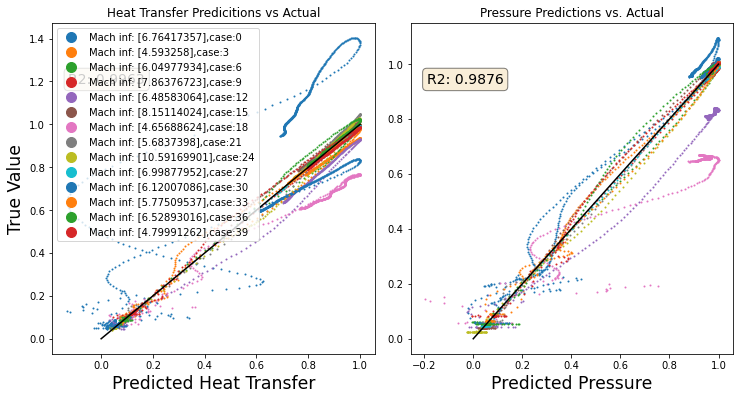

In [ ]:
desiredNumCasesForPlot = 20
totalCases = len(X_test[:,0])
casePlotRange= np.arange(0,totalCases,int((totalCases/desiredNumCasesForPlot)))
casePlotRange= np.arange(0,totalCases,3)

plt.rcParams["figure.figsize"] = (10,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)
fig.patch.set_facecolor('white')
    
for i, case in enumerate(casePlotRange):
    labelstr = 'Mach inf: ' + str(M_inf_test[case]) + ',case:' + str(case)
    maxHeatTransfer = qw_HF_krig_test_predict[case,:].max()
    maxPressure = p_HF_krig_test_predict[case,:].max()
    axs[0].scatter(qw_HF_krig_test_predict[case,:]/maxHeatTransfer,qw_HF_test_truth[case,:]/maxHeatTransfer, s=1, label = labelstr )
    axs[1].scatter(p_HF_krig_test_predict[case,:]/maxPressure,p_HF_test_truth[case,:]/maxPressure, s=1, label = labelstr)


    
axs[1].plot([0, 1], [0, 1], color = 'k')
axs[0].plot([0, 1], [0, 1], color = 'k')
# axs[0].scatter(qw_predicted[389,:],qw[389,:], s=1, label = 'Case 389' )
# axs[1].scatter(p_predicted[389,:],p[389,:], s=1)

qw_HF_krig_R2 = 'R2: ' + str(round(r2_score(qw_HF_test_truth, qw_HF_krig_test_predict),4))
p_HF_krig_R2 = 'R2: ' + str(round(r2_score(p_HF_test_truth, p_HF_krig_test_predict),4))

axs[0].text(0.05, 0.85, qw_HF_krig_R2, transform=axs[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)
axs[1].text(0.05, 0.85, p_HF_krig_R2, transform=axs[1].transAxes, fontsize=14, verticalalignment='top', bbox=props)
axs[0].set_title("Heat Transfer Predicitions vs Actual")
axs[1].set_title("Pressure Predictions vs. Actual")
axs[0].grid()
axs[1].grid()
axs[0].set_ylabel("True Value")
axs[0].set_xlabel("Predicted Heat Transfer")
axs[1].set_xlabel("Predicted Pressure")
axs[0].legend(markerscale=10)
# axs[1].legend(markerscale=10)

plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py

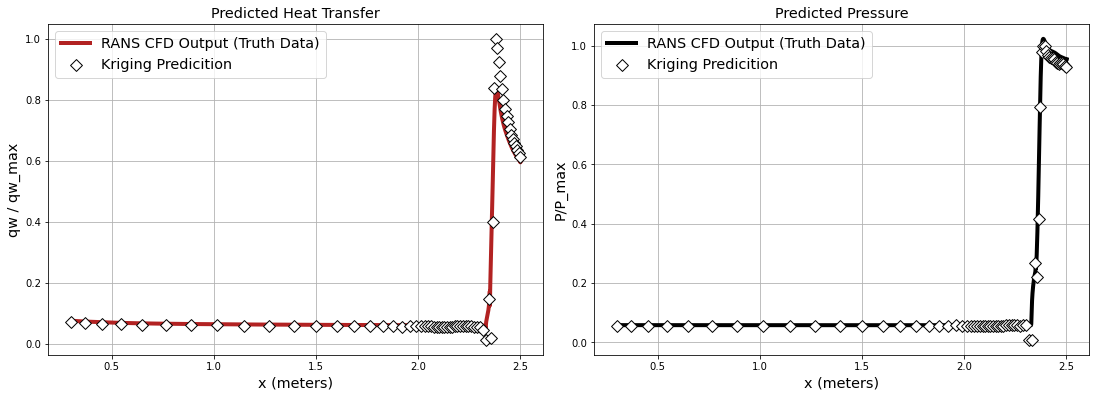

In [ ]:
totalCases = len(qw_HF_test_truth[:,0])
case = random.randint(0,totalCases-1)#Select the run that you would like to plot
case = 30
sliceVal = 20 # this is the "ol' fashioned way" for the plt.plot argument "markevery=sliceVal." The command doesn't work in plt.scatter

plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0.4, w_pad=2.0, h_pad=1.5)
fig.patch.set_facecolor('white')

# axs[0].scatter(qw_HF_krig_test_predict[case,:]/maxHeatTransfer,qw_HF_test_truth[case,:]/maxHeatTransfer, s=1, label = labelstr )
# axs[1].scatter(p_HF_krig_test_predict[case,:]/maxPressure,p_HF_test_truth[case,:]/maxPressure, s=1, label = labelstr)

maxHeatTransfer = qw_HF_krig_test_predict[case,:].max()
maxPressure = p_HF_krig_test_predict[case,:].max()

# plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
axs[0].plot(x_cc_sorted[0,idxWindowStart:], qw_HF_test_truth[case,:]/maxHeatTransfer, color='firebrick', linestyle='solid', linewidth=4, label='RANS CFD Output (Truth Data)')
axs[0].scatter(x_cc_sorted[0,idxWindowStart::sliceVal], qw_HF_krig_test_predict[case,::sliceVal]/maxHeatTransfer, c='white',
               zorder=3,edgecolors='black', marker='D', s=70, label='Kriging Predicition')
axs[0].set_title("Predicted Heat Transfer",fontsize='x-large')
axs[0].set_ylabel("qw / qw_max", fontsize='x-large')

# plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
axs[1].plot(x_cc_sorted[0,idxWindowStart:], p_HF_test_truth[case,:]/maxPressure, color='black', linestyle='solid', linewidth=4, label='RANS CFD Output (Truth Data)')
axs[1].scatter(x_cc_sorted[0,idxWindowStart::sliceVal], p_HF_krig_test_predict[case,::sliceVal]/maxPressure, c='white',
               zorder=3,edgecolors='black', marker='D', s=70, label='Kriging Predicition')
axs[1].set_title("Predicted Pressure", fontsize='x-large')
axs[1].set_ylabel("P/P_max", fontsize='x-large')

for i in np.arange(0,len(axs)):
    # axs[i].grid()
    axs[i].legend(fontsize='x-large')
    axs[i].set_xlabel('x (meters)',fontsize='x-large')
    # axs[i].text(0.05, 0.55, textstr, transform=axs[i].transAxes, fontsize=14,
    #     verticalalignment='top', bbox=props)

## Mean Predicition and Truth

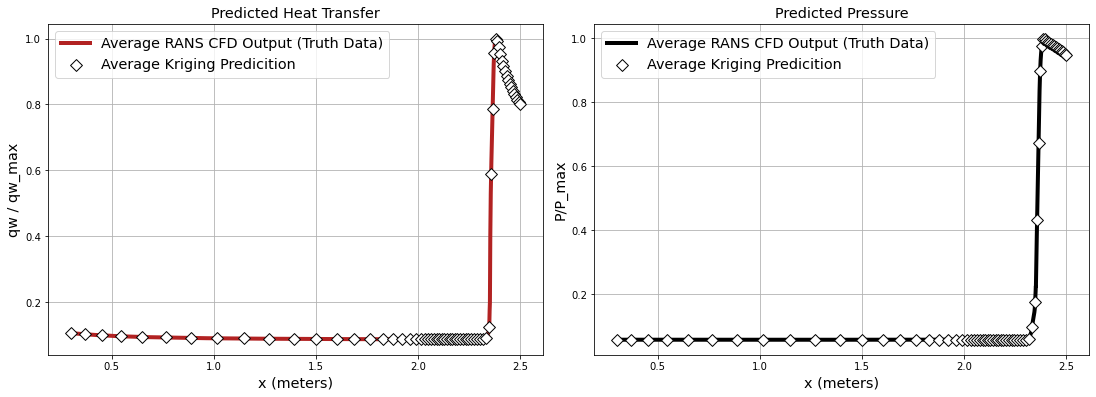

In [ ]:
totalCases = len(qw_HF_test_truth[:,0])
sliceVal = 20 # this is the "ol' fashioned way" for the plt.plot argument "markevery=sliceVal." The command doesn't work in plt.scatter

plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0.4, w_pad=2.0, h_pad=1.5)
fig.patch.set_facecolor('white')

mean_qw_HF_krig_test_predict = np.mean(qw_HF_krig_test_predict, axis=0)
mean_p_HF_krig_test_predict = np.mean(p_HF_krig_test_predict, axis=0)

mean_qw_HF_test_truth = np.mean(qw_HF_test_truth, axis=0)
mean_p_HF_test_truth = np.mean(p_HF_test_truth, axis=0)

maxHeatTransfer = mean_qw_HF_krig_test_predict.max()
maxPressure = mean_p_HF_krig_test_predict.max()

# plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
axs[0].plot(x_cc_sorted[0,idxWindowStart:], mean_qw_HF_test_truth/maxHeatTransfer, color='firebrick', linestyle='solid', linewidth=4, label='Average RANS CFD Output (Truth Data)')
axs[0].scatter(x_cc_sorted[0,idxWindowStart::sliceVal], mean_qw_HF_krig_test_predict[::sliceVal]/maxHeatTransfer, c='white',
               zorder=3,edgecolors='black', marker='D', s=70, label='Average Kriging Predicition')
axs[0].set_title("Predicted Heat Transfer",fontsize='x-large')
axs[0].set_ylabel("qw / qw_max", fontsize='x-large')

# plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
axs[1].plot(x_cc_sorted[0,idxWindowStart:], mean_p_HF_test_truth/maxPressure, color='black', linestyle='solid', linewidth=4, label='Average RANS CFD Output (Truth Data)')
axs[1].scatter(x_cc_sorted[0,idxWindowStart::sliceVal], mean_p_HF_krig_test_predict[::sliceVal]/maxPressure, c='white',
               zorder=3,edgecolors='black', marker='D', s=70, label='Average Kriging Predicition')
axs[1].set_title("Predicted Pressure", fontsize='x-large')
axs[1].set_ylabel("P/P_max", fontsize='x-large')

for i in np.arange(0,len(axs)):
    # axs[i].grid()
    axs[i].legend(fontsize='x-large')
    axs[i].set_xlabel('x (meters)',fontsize='x-large')
    # axs[i].text(0.05, 0.55, textstr, transform=axs[i].transAxes, fontsize=14,
    #     verticalalignment='top', bbox=props)

In [ ]:
HF_krig_NRMSE_pressure = normalizedRootMeanSquaredError(p_HF_test_truth,p_HF_krig_test_predict)
HF_krig_NRMSE_heatTransfer = normalizedRootMeanSquaredError(qw_HF_test_truth,qw_HF_krig_test_predict)

In [ ]:
print(HF_krig_NRMSE_heatTransfer*100)
print(HF_krig_NRMSE_pressure*100)

0.46588789362978394
0.40747970385405907


## One to One Plot Visualizations

https://stackoverflow.com/questions/33275189/how-can-i-make-points-of-a-python-plot-appear-over-time?noredirect=1&lq=1

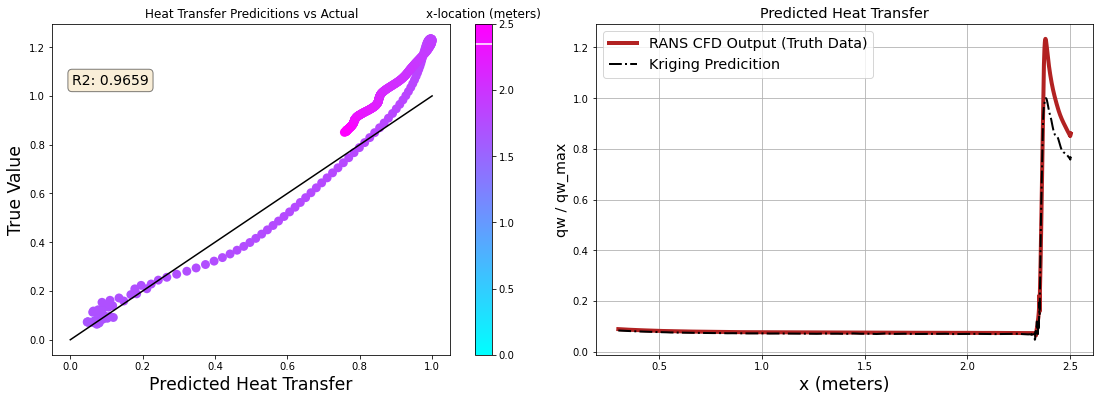

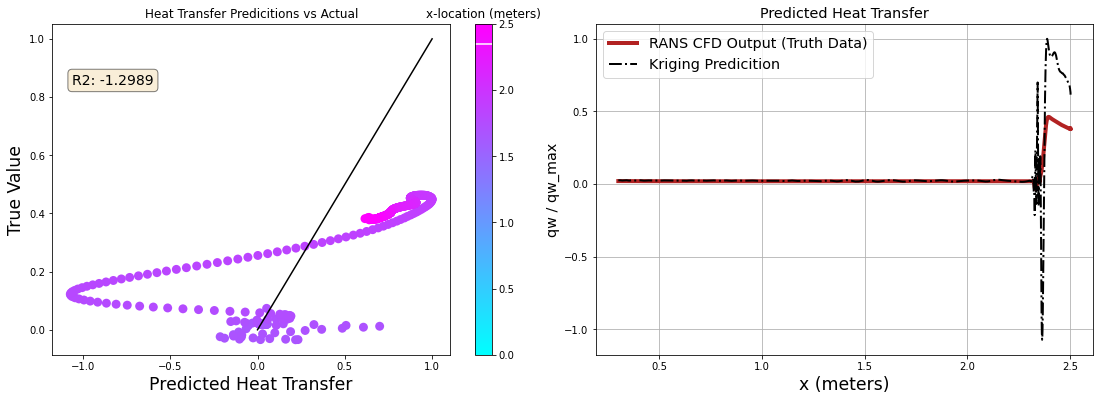

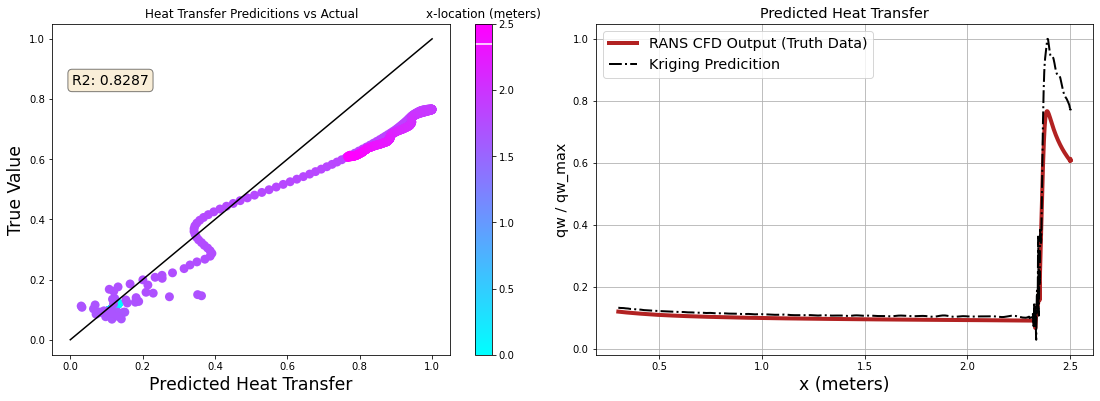

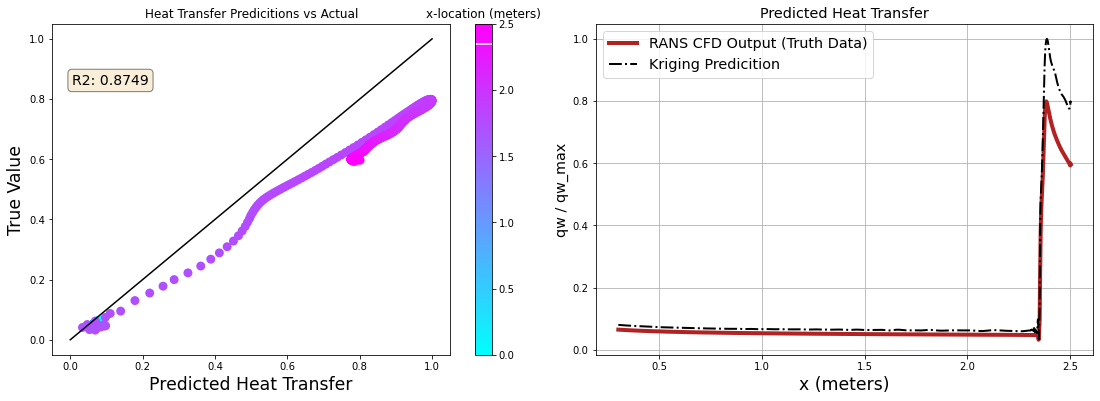

In [ ]:
%matplotlib inline
# for case in np.arange(0,40):
#     oneToOneVisualizationPlot(case=case)
    
oneToOneVisualizationPlot(case=2)
oneToOneVisualizationPlot(case=32)
oneToOneVisualizationPlot(case=18)
oneToOneVisualizationPlot(case=31)

# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation

# x = np.arange(10)
# y = np.random.random(10)

# fig = plt.figure()
# plt.xlim(0, 10)
# plt.ylim(0, 1)
# graph, = plt.plot([], [], 'o')

# def animate(i):
#     graph.set_data(x[:i+1], y[:i+1])
#     return graph

# ani = FuncAnimation(fig, animate, frames=10, interval=200)
# plt.show()

# Artificial Neural Network
Below are the functions that create and train the Neural Network models

The functions can become more robust by using *kwargs instead of layer1size, etc.... but for another day 

## Initialize Hyperparameters

### NN-specific data processing

I've built the neural network to intake 4 operating conditions (assembled in a list) and output 2 distributions (also assembled in a list), so we're splitting the data back up again. 

In [ ]:
# What would you like to do? Load an old model? Train and save a new model?

HFNNLoad = False
HFNNTrain = False
HFNNSave = True

In [ ]:
#Initialize hyperparamters for Single Fidelity Model
if HFNNTrain: 
    layer1size = 32 
    layer2size = 64
    numOutputData = 2
    rate = 1.0e-3 #From Deep Learning w/ Python (Chollet)
    # rate = 5.0e-2 # used by Dr. Reasor
    reg = 1.0e-6
    numEpochs = 1000
    myBatchSize = None
    validSplit = None

    inputTrainingData_NN = np.hsplit(X_train, 4)
    inputTestData_NN = np.hsplit(X_test, 4)

    outputTrainingData_NN = np.hsplit(y_train,2)
    outputTestData_NN = np.hsplit(y_test, 2)

    print("inputTrainingData_NN shape: {}".format(np.shape(inputTrainingData_NN)))
    print("inputTestData_NN shape: {}".format(np.shape(inputTestData_NN)))
    print("inputTrainingData shape: {}\n".format(np.shape(inputTrainingData)))

    print("outputTrainingData_NN shape: {}".format(np.shape(outputTrainingData_NN)))
    print("outputTestData_NN shape: {}".format(np.shape(outputTestData_NN)))
    print("outputTrainingData shape: {}".format(np.shape(outputTrainingData)))

inputTrainingData_NN shape: (4, 320, 1)
inputTestData_NN shape: (4, 40, 1)
inputTrainingData shape: (4, 400, 1)

outputTrainingData_NN shape: (2, 320, 1284)
outputTestData_NN shape: (2, 40, 1284)
outputTrainingData shape: (2, 400, 1284)


## Build Model and Plot Graph

In [ ]:
if HFNNTrain: 

    numCases = str(len(WallTemp_Scaled[:,0]))
    inputArraySize = str(WallTemp_Scaled.shape)
    outputArraySize = str(qw_Scaled.shape)
    numInput = str(len(inputVarNames))
    numOutput = str(len(outputVarNames))
    singleOutput = str(len(qw_Scaled[0,:]))

    print('We are using %s cases. Meaning each input array is %s, each output array is %s \n' % 
          (numCases, inputArraySize, outputArraySize))
    print('Note: The network, as depicted below, will take data from one case at a time. Therefore,'
         'the input data will be %s 1x1 arrays, and the output will be %s 1x%s arrays \n \n \n' % (numInput, numOutput, singleOutput ))
    HF_NN = None #sometimes remnants of previously trained models can hang around, it's best to clear the variable first 
    HF_NN = build_model_single_fidelity(WallTemp_Scaled, qw_Scaled, numOutputData, layer1size, layer2size, rate, reg)

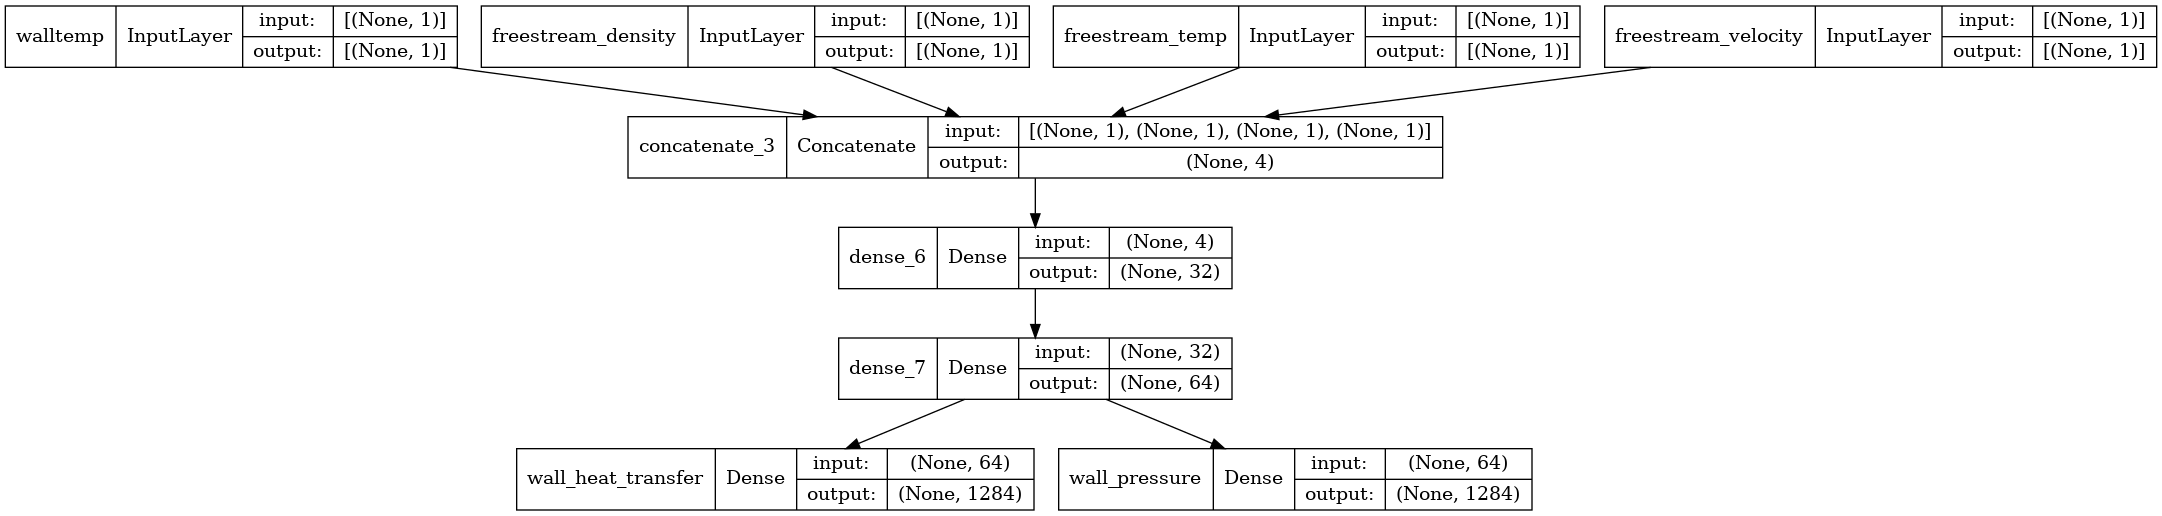

In [ ]:
if HFNNTrain: 

#     numCases = str(len(inputTrainingData_NN[0]))
#     inputArraySize = str(WallTemp_Scaled.shape)
#     outputArraySize = str(qw_Scaled.shape)
#     numInput = str(len(inputVarNames))
#     numOutput = str(len(outputVarNames))
#     singleOutput = str(len(qw_Scaled[0,:]))

#     print('We are using %s cases. Meaning each input array is %s, each output array is %s \n' % 
#           (numCases, inputArraySize, outputArraySize))
#     print('Note: The network, as depicted below, will take data from one case at a time. Therefore,'
#          'the input data will be %s 1x1 arrays, and the output will be %s 1x%s arrays \n \n \n' % (numInput, numOutput, singleOutput ))
    HF_NN = None #sometimes remnants of previously trained models can hang around, it's best to clear the variable first 
    HF_NN = build_model_single_fidelity(inputTrainingData_NN[0], outputTrainingData_NN[0], numOutputData, layer1size, layer2size, rate, reg)
tf.keras.utils.plot_model(HF_NN,show_shapes=True)

## Train the Model

In [ ]:
if HFNNTrain: 

    HF_NN_epochs = None
    HF_NN_history = None

    HF_NN_epochs, HF_NN_history = train_model_all_fidelity(
        HF_NN, inputTrainingData_NN, outputTrainingData_NN, numEpochs, myBatchSize, validSplit)

## Save and Load Data
Only run the below cell if you desire to save the model. We'll also save the history dict in a pickle file. 

### Save NN, History, and Epochs

In [ ]:
if HFNNSave:

    # The try/except syntax catches the error if we've already created the directory. 
    path = "/home/tyty/Desktop/CFD_Files/MFmodelTestData"
    kerasFolderName = 'HF_NN_'
    dt = str(datetime.date.today())
    kerasFolderName += dt

    try: 
        os.chdir(path)
        mkdirPath = os.path.join(path, kerasFolderName)
        os.mkdir(mkdirPath)
    except: 
        pass 

    # We won't be saving the NN in the same way that we save the GP model. Keras likes to save all kind of other stuff, with no intuitive way to change the file names.
    # For version control purposes (really, to make sure we're not overwriting old models), we'll create a new folder for each saved model with the date included. 

    path = "/home/tyty/Desktop/CFD_Files/MFmodelTestData"
    path += '/' + kerasFolderName
    os.chdir(path)

    model = HF_NN
    model.save(path)

# Let's save the history and epoch data in a dictionary as well.

    epochsDict = HF_NN_epochs
    historyDict = HF_NN_history

    epochsFilename = 'HF_NN_epochs'
    historyFilename = 'HF_NN_history'
    dt = str(datetime.date.today())
    ext = '.pkl'
    epochsFilename += '_' + dt + ext
    historyFilename += '_' + dt + ext
    pickle.dump(epochsDict, open(epochsFilename, 'wb'))
    pickle.dump(historyDict, open(historyFilename, 'wb'))

INFO:tensorflow:Assets written to: /home/tyty/Desktop/CFD_Files/MFmodelTestData/RANS_NN_2022-04-15/assets


### Load NN

In [ ]:
if HFNNLoad: 
    # Loading the NN is a bit easier-- but you'll need to specify the path. An example path is included already, which will need to be edited if you wish to load a different model. 
    path = '/home/tyty/Desktop/CFD_Files/MFmodelTestData/HF_NN_2022-02-26'
    os.chdir(path)
    loadedModelName = 'HF_NN_loaded'

    locals()[loadedModelName] = keras.models.load_model(path)

### Load History and Epochs 
    # some time later... load the model from disk

    # path variable should already be defined from when you loaded the NN model. If not, uncomment the 2 lines below. 
    # path = '/home/tyty/Desktop/CFD_Files/MFmodelTestData/HF_NN_2022-02-11'
    # os.chdir(path)

    epochsFilename = 'HF_NN_epochs_2022-02-26.pkl'
    historyFilename = 'HF_NN_history_2022-02-26.pkl'

    desiredLoadedEpochsName = 'HF_NN_epochs_loaded'
    desiredLoadedHistoryName = 'HF_NN_history_loaded'

    locals()[desiredLoadedEpochsName] = pickle.load(open(epochsFilename, 'rb'))
    locals()[desiredLoadedHistoryName] = pickle.load(open(historyFilename, 'rb'))

## Overwrite current loaded model? 

    HF_NN = None
    HF_NN_epochs = None
    HF_NN_history = None
    HF_NN = HF_NN_loaded
    HF_NN_epochs = HF_NN_epochs_loaded
    HF_NN_history = HF_NN_history_loaded

## Summary of Model

In [ ]:
HF_NN.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 walltemp (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 freestream_density (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 freestream_temp (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 freestream_velocity (InputLaye  [(None, 1)]         0           []                         

## Analyze Error (MSE)

Mean Squared Error 3.4257156 percent


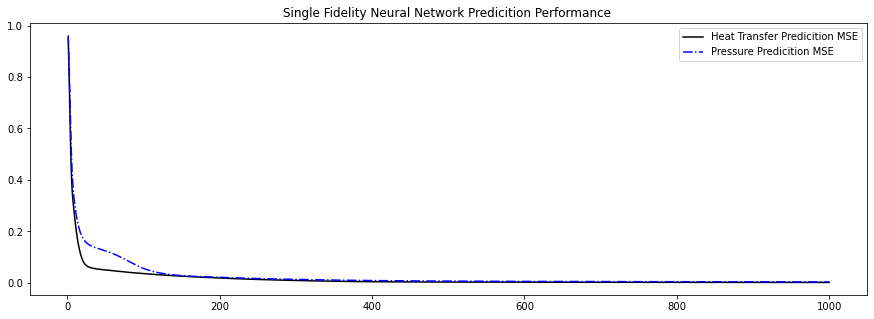

In [ ]:
mse_history_qw = HF_NN_history["wall_heat_transfer_mean_squared_error"]
mse_history_P = HF_NN_history["wall_pressure_mean_squared_error"]

# Input the desired epoch range

epochRangeBegin = 0 
epochRangeEnd = 5000

plt.plot(range(1,len(mse_history_qw[epochRangeBegin:epochRangeEnd]) + 1),
         mse_history_qw[epochRangeBegin:epochRangeEnd],
         label="Heat Transfer Predicition MSE",linestyle="-", color="k")
plt.plot(range(1,len(mse_history_P[epochRangeBegin:epochRangeEnd]) + 1),
         mse_history_P[epochRangeBegin:epochRangeEnd],
         label="Pressure Predicition MSE",linestyle="-.", color="b")
plt.title("Single Fidelity Neural Network Predicition Performance ")
plt.legend(loc=0)
plt.grid()

minError = np.min(HF_NN_history["wall_heat_transfer_mean_squared_error"])
MSE = np.sqrt(minError)
print('Mean Squared Error %0.7f percent' % (MSE*100, ))

## Generate and Inverse Transform Predictions

In [ ]:
# Now that we have a prediction, we'll need inverse transform and see how well we did. 

numTestCases = len(inputTestData_NN[0][:,0])
numTrainCases = len(inputTrainingData_NN[0][:,0])

start = time.time()
[qw_HF_NN_test_predict, p_HF_NN_test_predict] = HF_NN.predict(inputTestData_NN)
end = time.time()
print('Prediction time per case (test data): %0.7f seconds, %0.3f Hz ' % (((end-start)/numTestCases), 1/((end-start)/numTestCases)) )

start = time.time()
[qw_HF_NN_train_predict, p_HF_NN_train_predict] = HF_NN.predict(inputTrainingData_NN)
end = time.time()
print('Prediction time per case (train data): %0.7f seconds, %0.3f Hz ' % (((end-start)/numTrainCases), 1/((end-start)/numTrainCases)) )

[qw_HF_train_truth, p_HF_train_truth] = np.hsplit(y_train, 2)
[qw_HF_test_truth, p_HF_test_truth] = np.hsplit(y_test, 2)

dataSplitNames = [
    '_HF_NN_test_predict',
    '_HF_NN_train_predict',
    '_HF_test_truth',
    '_HF_train_truth',
]

for name in outputVarNames:
    ScalerName = name + '_OutputScaler'
    for tail in dataSplitNames:
        fullName = name + tail
        locals()[fullName] = locals()[ScalerName].inverse_transform(locals()[fullName])
        print(fullName + ' has been inverse transformed! It is called ' + fullName)

Prediction time per case (test data): 0.0026346 seconds, 379.560 Hz 
Prediction time per case (train data): 0.0003570 seconds, 2801.128 Hz 
qw_HF_NN_test_predict has been inverse transformed! It is called qw_HF_NN_test_predict
qw_HF_NN_train_predict has been inverse transformed! It is called qw_HF_NN_train_predict
qw_HF_test_truth has been inverse transformed! It is called qw_HF_test_truth
qw_HF_train_truth has been inverse transformed! It is called qw_HF_train_truth
p_HF_NN_test_predict has been inverse transformed! It is called p_HF_NN_test_predict
p_HF_NN_train_predict has been inverse transformed! It is called p_HF_NN_train_predict
p_HF_test_truth has been inverse transformed! It is called p_HF_test_truth
p_HF_train_truth has been inverse transformed! It is called p_HF_train_truth


## Analyze Predictions
For 20 cases, we have plotted the predicted value vs. the actual value. A perfect prediciton would be a straight line with a slope of 1. 

Text(0.5, 24.0, 'Predicted Pressure')

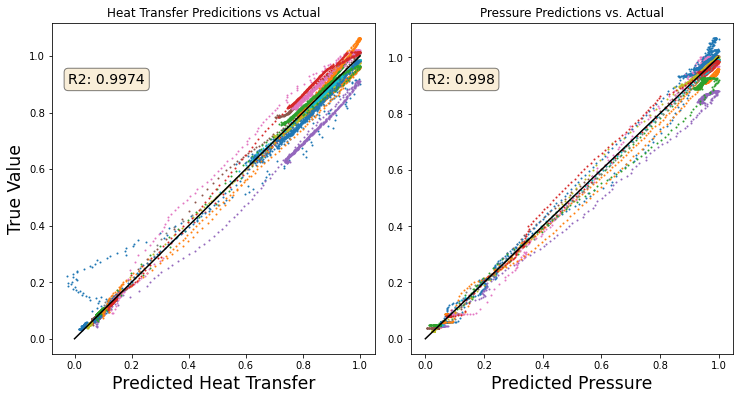

In [ ]:
desiredNumCasesForPlot = 20
totalCases = len(X_test[:,0])
casePlotRange= np.arange(0,totalCases,int((totalCases/desiredNumCasesForPlot)))
casePlotRange= np.arange(0,totalCases,3)

plt.rcParams["figure.figsize"] = (10,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)
fig.patch.set_facecolor('white')

for case in casePlotRange:
    caseStr = 'Case: ' + str(case)
    maxHeatTransfer = qw_HF_NN_test_predict[case,:].max()
    maxPressure = p_HF_NN_test_predict[case,:].max()
    axs[0].scatter(qw_HF_NN_test_predict[case,:]/maxHeatTransfer,qw_HF_test_truth[case,:]/maxHeatTransfer, s=1, label = caseStr)
    axs[1].scatter(p_HF_NN_test_predict[case,:]/maxPressure,p_HF_test_truth[case,:]/maxPressure, s=1, label = caseStr)

qw_HF_NN_R2 = 'R2: ' + str(round(r2_score(qw_HF_test_truth, qw_HF_NN_test_predict),4))
p_HF_NN_R2 = 'R2: ' + str(round(r2_score(p_HF_test_truth, p_HF_NN_test_predict),4))

axs[0].text(0.05, 0.85, qw_HF_NN_R2, transform=axs[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)
axs[1].text(0.05, 0.85, p_HF_NN_R2, transform=axs[1].transAxes, fontsize=14, verticalalignment='top', bbox=props)    
axs[0].plot([0, 1], [0, 1], color = 'k')
axs[1].plot([0, 1], [0, 1], color = 'k')
axs[0].set_title("Heat Transfer Predicitions vs Actual")
axs[1].set_title("Pressure Predictions vs. Actual")
axs[0].grid()
axs[1].grid()
axs[0].set_ylabel("True Value")
axs[0].set_xlabel("Predicted Heat Transfer")
axs[1].set_xlabel("Predicted Pressure")

# axs[0].legend(markerscale=8)

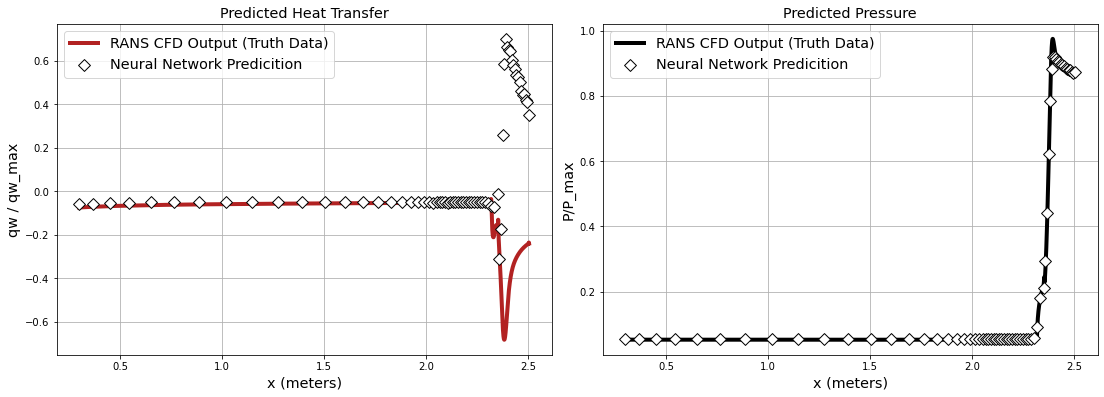

In [ ]:
totalCases = len(qw_HF_test_truth[:,0])
case = random.randint(0,totalCases-1)#Select the run that you would like to plot
case = 26
sliceVal = 20 # this is the "ol' fashioned way" for the plt.plot argument "markevery=sliceVal." The command doesn't work in plt.scatter

plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0.4, w_pad=2.0, h_pad=1.5)
fig.patch.set_facecolor('white')

# axs[0].scatter(qw_HF_krig_test_predict[case,:]/maxHeatTransfer,qw_HF_test_truth[case,:]/maxHeatTransfer, s=1, label = labelstr )
# axs[1].scatter(p_HF_krig_test_predict[case,:]/maxPressure,p_HF_test_truth[case,:]/maxPressure, s=1, label = labelstr)

maxHeatTransfer = qw_HF_krig_test_predict[case,:].max()
maxPressure = p_HF_krig_test_predict[case,:].max()

# plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
axs[0].plot(x_cc_sorted[0,idxWindowStart:], qw_HF_test_truth[case,:]/maxHeatTransfer, color='firebrick', linestyle='solid', linewidth=4, label='RANS CFD Output (Truth Data)')
axs[0].scatter(x_cc_sorted[0,idxWindowStart::sliceVal], qw_HF_NN_test_predict[case,::sliceVal]/maxHeatTransfer, c='white',
               zorder=3,edgecolors='black', marker='D', s=70, label='Neural Network Predicition')
axs[0].set_title("Predicted Heat Transfer",fontsize='x-large')
axs[0].set_ylabel("qw / qw_max", fontsize='x-large')

# plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
axs[1].plot(x_cc_sorted[0,idxWindowStart:], p_HF_test_truth[case,:]/maxPressure, color='black', linestyle='solid', linewidth=4, label='RANS CFD Output (Truth Data)')
axs[1].scatter(x_cc_sorted[0,idxWindowStart::sliceVal], p_HF_NN_test_predict[case,::sliceVal]/maxPressure, c='white',
               zorder=3,edgecolors='black', marker='D', s=70, label='Neural Network Predicition')
axs[1].set_title("Predicted Pressure", fontsize='x-large')
axs[1].set_ylabel("P/P_max", fontsize='x-large')

for i in np.arange(0,len(axs)):
    # axs[i].grid()
    axs[i].legend(fontsize='x-large')
    axs[i].set_xlabel('x (meters)',fontsize='x-large')
    # axs[i].text(0.05, 0.55, textstr, transform=axs[i].transAxes, fontsize=14,
    #     verticalalignment='top', bbox=props)

In [ ]:
HF_NN_NRMSE_pressure = normalizedRootMeanSquaredError(p_HF_test_truth,p_HF_NN_test_predict)
HF_NN_NRMSE_heatTransfer = normalizedRootMeanSquaredError(qw_HF_test_truth,qw_HF_NN_test_predict)
print(HF_NN_NRMSE_pressure*100)
print(HF_NN_NRMSE_heatTransfer*100)

0.227707935735766
0.3704814819503433


## Mean Predicition and Truth

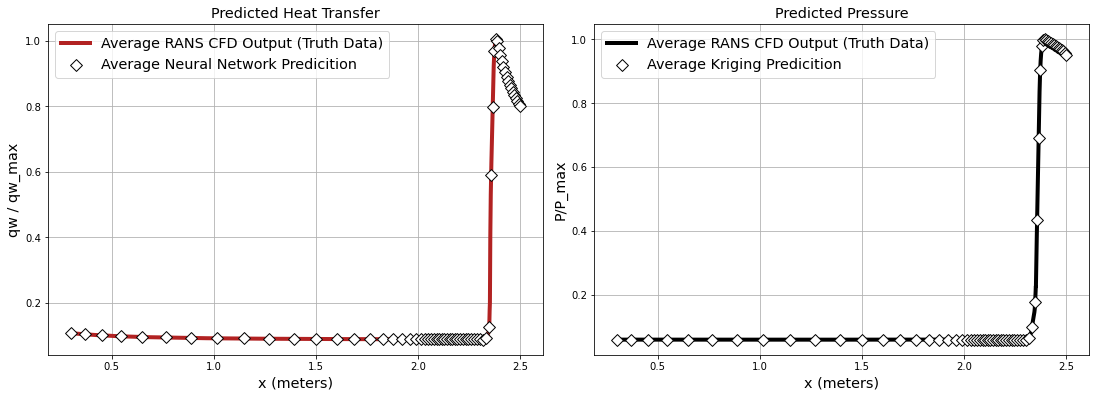

In [ ]:
totalCases = len(qw_HF_test_truth[:,0])
sliceVal = 20 # this is the "ol' fashioned way" for the plt.plot argument "markevery=sliceVal." The command doesn't work in plt.scatter

plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0.4, w_pad=2.0, h_pad=1.5)
fig.patch.set_facecolor('white')

mean_qw_HF_NN_test_predict = np.mean(qw_HF_NN_test_predict, axis=0)
mean_p_HF_NN_test_predict = np.mean(p_HF_NN_test_predict, axis=0)

mean_qw_HF_test_truth = np.mean(qw_HF_test_truth, axis=0)
mean_p_HF_test_truth = np.mean(p_HF_test_truth, axis=0)

maxHeatTransfer = mean_qw_HF_krig_test_predict.max()
maxPressure = mean_p_HF_krig_test_predict.max()

# plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
axs[0].plot(x_cc_sorted[0,idxWindowStart:], mean_qw_HF_test_truth/maxHeatTransfer, color='firebrick', linestyle='solid', linewidth=4, label='Average RANS CFD Output (Truth Data)')
axs[0].scatter(x_cc_sorted[0,idxWindowStart::sliceVal], mean_qw_HF_NN_test_predict[::sliceVal]/maxHeatTransfer, c='white',
               zorder=3,edgecolors='black', marker='D', s=70, label='Average Neural Network Predicition')
axs[0].set_title("Predicted Heat Transfer",fontsize='x-large')
axs[0].set_ylabel("qw / qw_max", fontsize='x-large')

# plt.plot(theta_rbf, Tw_rbf, color='black', linestyle='solid', linewidth=2, marker='D', markersize=6,     mfc='white', markevery=5, label='RBF')
axs[1].plot(x_cc_sorted[0,idxWindowStart:], mean_p_HF_test_truth/maxPressure, color='black', linestyle='solid', linewidth=4, label='Average RANS CFD Output (Truth Data)')
axs[1].scatter(x_cc_sorted[0,idxWindowStart::sliceVal], mean_p_HF_NN_test_predict[::sliceVal]/maxPressure, c='white',
               zorder=3,edgecolors='black', marker='D', s=70, label='Average Kriging Predicition')
axs[1].set_title("Predicted Pressure", fontsize='x-large')
axs[1].set_ylabel("P/P_max", fontsize='x-large')

for i in np.arange(0,len(axs)):
    # axs[i].grid()
    axs[i].legend(fontsize='x-large')
    axs[i].set_xlabel('x (meters)',fontsize='x-large')
    # axs[i].text(0.05, 0.55, textstr, transform=axs[i].transAxes, fontsize=14,
    #     verticalalignment='top', bbox=props)

# Multi-Fidelity Modeling

## MF Kriging

### Choose Desired Action

In [ ]:
#Would you like to train a new model? 
trainMultiFidelityKrig = False

#Would you like to save your model? 
saveMultiFidelityKrig = False

#Would you like to load a previously trained model ?
loadMultiFidelityKrig = True

#If you have trained a model in this same workspace as well as loaded a model, would you like to overwrite with your loaded model? 
#If you have not trained a model, but loaded a model, then leave this "True"
if not trainMultiFidelityKrig and loadMultiFidelityKrig: 
    overwriteMultiFidelityKrig = True

In [ ]:
inputDataConcat = np.concatenate((WallTemp_Scaled,Density_Scaled,Temperature_Scaled,Velocity_Scaled),axis=1)
outputDataConcat = np.concatenate((qw_Scaled,p_Scaled),axis=1)

HFinputTrainingData = inputDataConcat #for now, let's change this later to see how the model performs

lowFidelityKriging_input = LF_krig.predict(HFinputTrainingData)
HFinputTrainingDataNp = np.array(HFinputTrainingData).reshape(4,400)
multiFidelityKrig_input = np.concatenate((HFinputTrainingDataNumpy.T,lowFidelityKriging_input),
                                    axis = 1)

In [ ]:
if trainMultiFidelityKrig:
    MF_krig = None
    MF_krig = gaussian_process.GaussianProcessRegressor(kernel=kernel2,n_restarts_optimizer=0)
    MF_krig.fit(multiFidelityKrig_input, outputDataConcat)

In [ ]:
if saveMultiFidelityKrig:
    path = "/home/tyty/Desktop/CFD_Files/MFmodelTestData"
    os.chdir(path)

    model = MF_krig
    filename = 'MF_krig_'
    dt = str(datetime.date.today())
    ext = '.sav'
    filename += dt + ext
    pickle.dump(model, open(filename, 'wb'))

In [ ]:
if loadMultiFidelityKrig:
    path = "/home/tyty/Desktop/CFD_Files/MFmodelTestData"
    os.chdir(path)

    filename = 'MF_krig_2022-03-21.sav'
    desiredLoadedModelName = 'MF_krig_loaded'

    locals()[desiredLoadedModelName] = pickle.load(open(filename, 'rb'))

if overwriteMultiFidelityKrig:
    MF_krig = None
    MF_krig = MF_krig_loaded

In [ ]:
MF_krig_prediction = MF_krig.predict(multiFidelityKrig_input)

### Split and Scale Output

In [ ]:
#Now we'll need to un-concatenate and scale the output predictions
outputDataSplit = int(outputDataConcat.shape[1]/len(outputVarNames))
indexStart = 0
indexEnd = outputDataSplit

outputPredictedData = []

for i, name in enumerate(outputVarNames):
    OutputDataName = name + '_predicted'
    locals()[OutputDataName] = MF_krig_prediction[:,indexStart:indexEnd]
    indexStart += outputDataSplit
    indexEnd += outputDataSplit
    
    ScalerName = name + '_OutputScaler'
    locals()[OutputDataName] = locals()[ScalerName].inverse_transform(globals()[OutputDataName])
    outputPredictedData.append(locals()[ScaledName])
    max_element = str(round(np.max(locals()[OutputDataName]),2))
    min_element = str(round(np.min(locals()[OutputDataName]),2))
    print(OutputDataName + ' has been inverse transformed! It is called ' + OutputDataName + 
          '. Min:' + min_element + '. Max:' + max_element)

qw_predicted has been inverse transformed! It is called qw_predicted. Min:-207081.92. Max:15916344.59
p_predicted has been inverse transformed! It is called p_predicted. Min:342.04. Max:1291816.01


Text(0.5, 24.0, 'Predicted Pressure')

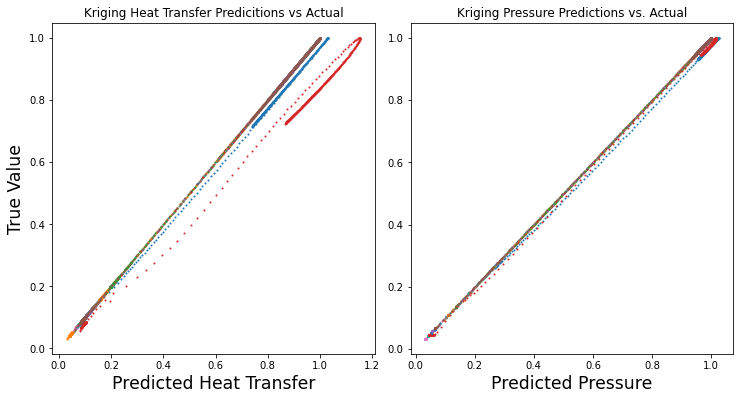

In [ ]:
desiredNumCasesForPlot = 15
casePlotRange= np.arange(0,400,int((400/desiredNumCasesForPlot)))

plt.rcParams["figure.figsize"] = (10,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)
fig.patch.set_facecolor('white')

  
for i, case in enumerate(casePlotRange):
    labelstr = 'Case: ' + str(case)
    maxHeatTransfer = qw[case,:].max()
    maxPressure = p[case,:].max()
    axs[0].scatter(qw_predicted[case,:]/maxHeatTransfer,qw[case,:]/maxHeatTransfer, s=1, label = labelstr )
    axs[1].scatter(p_predicted[case,:]/maxPressure,p[case,:]/maxPressure, s=1, label = labelstr)


    
# axs[0].scatter(qw_predicted[389,:],qw[389,:], s=1, label = 'Case 389' )
# axs[1].scatter(p_predicted[389,:],p[389,:], s=1)
# axs[0].legend()
# axs[1].legend()
axs[0].set_title("Kriging Heat Transfer Predicitions vs Actual")
axs[1].set_title("Kriging Pressure Predictions vs. Actual")
axs[0].grid()
axs[1].grid()
axs[0].set_ylabel("True Value")
axs[0].set_xlabel("Predicted Heat Transfer")
axs[1].set_xlabel("Predicted Pressure")

In [ ]:
caseWePick

291

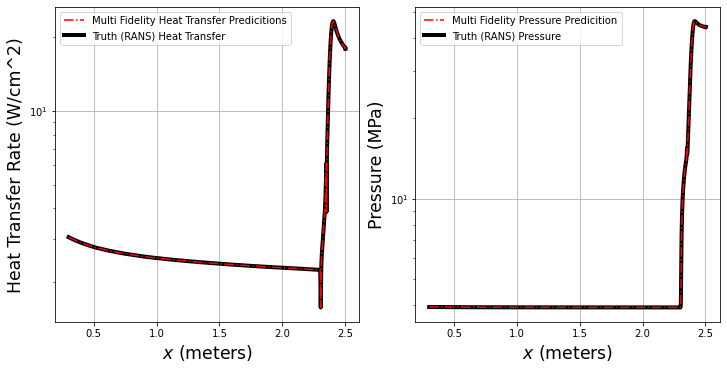

In [ ]:
caseWePick = random.randint(0,399)
caseWePick = 299
sliceVal = 25 # this is the "ol' fashioned way" for the plt.plot argument "markevery=sliceVal." The command doesn't work in plt.scatter
plt.rcParams["figure.figsize"] = (10,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=1.2, w_pad=2.5, h_pad=.5)
fig.patch.set_facecolor('white')

axs[0].semilogy(x_cc_windowed[0,:],qw_predicted[caseWePick,:]/10000,
                label = 'Multi Fidelity Heat Transfer Predicitions', linestyle = '-.', color = 'red', zorder=3)
axs[0].semilogy(x_cc_windowed[0,:],qw[caseWePick,:]/10000,
                label = 'Truth (RANS) Heat Transfer',color='black', linestyle='solid',
                linewidth=4)

# axs[0].scatter(
#     x_cc_windowed[0,::sliceVal],
#     qw_predicted[caseWePick,::sliceVal],
#     c='white', zorder=3,edgecolors='black', marker='D', s=70, label='Neural Network Predicition')

axs[1].semilogy(x_cc_windowed[0,:],p_predicted[caseWePick,:]*1e-3,
                label = 'Multi Fidelity Pressure Predicition', linestyle = '-.', color = 'red',zorder=3)
axs[1].semilogy(x_cc_windowed[0,:],p[caseWePick,:]*1e-3, 
                label = 'Truth (RANS) Pressure',color='black', linestyle='solid',
                linewidth=4)
# axs[0].scatter(
#     x_cc_windowed[0,::sliceVal],
#     qw_predicted[caseWePick,::sliceVal],
#     c='white', zorder=3,edgecolors='black', marker='D', s=70, label='Neural Network Predicition')


# xlim([min(x)-.1 max(x)+.1])
axs[0].set_xlabel('$x$ (meters)')
axs[0].set_ylabel('Heat Transfer Rate (W/cm^2)')

axs[1].set_xlabel('$x$ (meters)')
axs[1].set_ylabel('Pressure (MPa)')

axs[0].legend()
axs[1].legend()

## MF Neural Network

### Choose Desired Action 

In [ ]:
#Would you like to train a new model? 
trainMultiFidelityNN = False

#Would you like to save your model? 
saveMultiFidelityNN = False

#Would you like to load a previously trained model ?
loadMultiFidelityNN = True

#If you have trained a model in this same workspace as well as loaded a model, would you like to overwrite with your loaded model? 
#If you have not trained a model, but loaded a model, then leave this "True"
if not trainMultiFidelityNN and loadMultiFidelityNN: 
    overwriteMultiFidelityNN = True

### Assemble Data, Build Model

### Flatten Training Data
Our training data are currently stored in 3D tensors. We need to flatten them to get them to play nice with the neural network and Kriging. 

In [ ]:
# This is an idea to make the model a bit smaller. Although it may be cheating. 
# MFinputData_truncated = np.concatenate((inputData, p_lowFidelity_SE_truncated), axis = 0)
# MFinputData_truncated.shape
# it uses only two points for pressure instead of the distribution -- since the pressure data is "tiled" from only two values, the pressure on the front cone and the pressure on the back cone 

HFinputTrainingData = inputTrainingData #for now, let's change this later to see how the model performs

lowFidelityNN_input = LF_NN.predict(HFinputTrainingData)

[q_lowFidelity_predicted, p_lowFidelity_SE_predicted] = LF_NN.predict(inputTrainingData)


flattenedLowFidelityNN_input = np.concatenate((q_lowFidelity_predicted, p_lowFidelity_SE_predicted),
                                    axis = 1)

HFinputTrainingDataNumpy = np.array(HFinputTrainingData).reshape(4,400)


multiFidelityNN_input = np.concatenate((HFinputTrainingDataNumpy.T,flattenedLowFidelityNN_input),
                                    axis = 1)

In [ ]:
# Directly feeding the low fidelity data into the model. No predictions from LF model. 

HFinputTrainingData = inputTrainingData #for now, let's change this later to see how the model performs

flattenedLowFidelityNN_input = np.concatenate((q_lowFidelity, p_lowFidelity_SE),
                                    axis = 1)

HFinputTrainingDataNumpy = np.array(HFinputTrainingData).reshape(4,400)

multiFidelityNN_input = np.concatenate((HFinputTrainingDataNumpy.T,flattenedLowFidelityNN_input),
                                    axis = 1)

In [ ]:
outputPredictedData = []

print('\nPredicted Output Data (stored in list outputPredictedData):\n')
for i, name in enumerate(LFoutputVarNames):
    ScalerName = name + '_OutputScaler'
    OutputDataName = name + '_predicted'
    locals()[OutputDataName] = locals()[ScalerName].inverse_transform(globals()[OutputDataName])
    outputPredictedData.append(locals()[ScaledName])
    max_element = str(round(np.max(locals()[OutputDataName]),2))
    min_element = str(round(np.min(locals()[OutputDataName]),2))
    print(OutputDataName + ' has been inverse transformed! It is called ' +
          OutputDataName + '. Min:' + min_element + '. Max:' + max_element)

# desiredNumCasesForPlot = 15
# casePlotRange= np.arange(0,400,int((400/desiredNumCasesForPlot)))

# plt.rcParams["figure.figsize"] = (10,5)
# fig, axs = plt.subplots(1, 2)
# fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)
# fig.patch.set_facecolor('white')

  
# for i, case in enumerate(casePlotRange):
#     labelstr = 'Case: ' + str(case)
#     maxHeatTransfer = q_lowFidelity[case,:].max()
#     maxPressure = p_lowFidelity_SE[case,:].max()
#     axs[0].scatter(q_lowFidelity_predicted[case,:]/maxHeatTransfer,q_lowFidelity[case,:]/maxHeatTransfer, s=1, label = labelstr )
#     axs[1].scatter(p_lowFidelity_SE_predicted[case,:]/maxPressure,p_lowFidelity_SE[case,:]/maxPressure, s=1, label = labelstr)


    
# # axs[0].scatter(qw_predicted[389,:],qw[389,:], s=1, label = 'Case 389' )
# # axs[1].scatter(p_predicted[389,:],p[389,:], s=1)

# axs[0].set_title("NN Heat Transfer Predicitions vs Actual")
# axs[1].set_title("NN Pressure Predictions vs. Actual")
# axs[0].grid()
# axs[1].grid()
# axs[0].set_ylabel("True Value")
# axs[0].set_xlabel("Predicted Heat Transfer")
# axs[1].set_xlabel("Predicted Pressure")


Predicted Output Data (stored in list outputPredictedData):

q_lowFidelity_predicted has been inverse transformed! It is called q_lowFidelity_predicted. Min:-4587.54. Max:2525152.0
p_lowFidelity_SE_predicted has been inverse transformed! It is called p_lowFidelity_SE_predicted. Min:-38232.08. Max:1769656.8


In [ ]:
outputTrainingData = []
outputTrainingNames = []

print('\nOutput Data (stored in list outputTrainingData):\n')
for i, name in enumerate(outputVarNames):
    ScalerName = name + '_OutputScaler'
    ScaledName = name + '_Scaled'
    OutputDataName = name
    locals()[ScalerName] = None
    locals()[ScalerName] = preprocessing.StandardScaler()
    locals()[ScaledName] = locals()[ScalerName].fit_transform(globals()[OutputDataName])
    outputTrainingData.append(locals()[ScaledName])
    outputTrainingNames.append(ScaledName)
    max_element = str(round(np.max(locals()[ScaledName]),2))
    min_element = str(round(np.min(locals()[ScaledName]),2))
    print(name + ' has been scaled! It is called ' +
          ScaledName + '. Min:' + min_element + '. Max:' + max_element)

multiFidelityNN_output = outputTrainingData


Output Data (stored in list outputTrainingData):

qw has been scaled! It is called qw_Scaled. Min:-1.59. Max:4.86
p has been scaled! It is called p_Scaled. Min:-1.6. Max:4.86


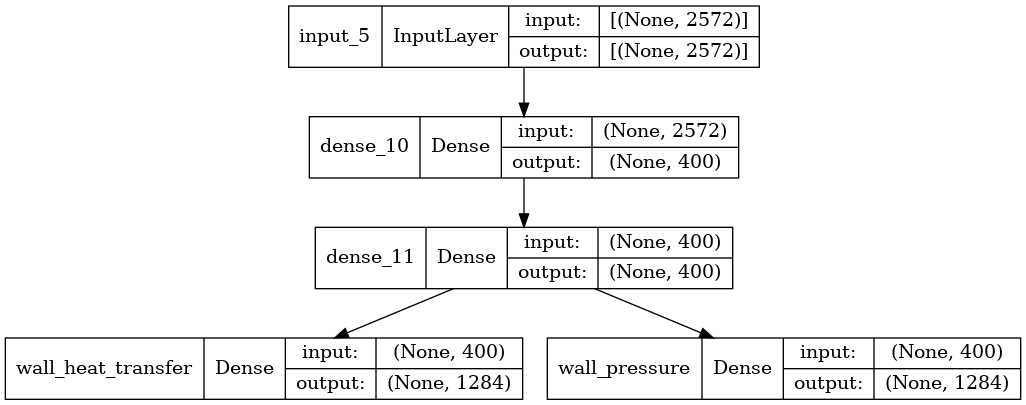

In [ ]:
if trainMultiFidelityNN: 

    # rate = 1.0e-4 #From Deep Learning w/ Python (Chollet)
    # rate = 5.0e-2 # used by Dr. Reasor
    rate = .001
    reg = 1.0e-6
    numEpochs = 10000
    myBatchSize = None
    validSplit = None
    # multiFidelityRefSize = int(len(multiFidelityNN_input[1]))*2
    multiFidelityRefSize = 400

    MF_NN = None
    MF_NN = build_model_multi_fidelity(
        input_data = multiFidelityNN_input,
        output_data = qw_Scaled,
        ref_size = multiFidelityRefSize,
        rate = rate,
        reg = reg
    )

tf.keras.utils.plot_model(MF_NN,show_shapes=True)

### Train Model

In [ ]:
#Initialize hyperparamters for Single Fidelity Model
if trainMultiFidelityNN: 

    MF_NN_epochs, MF_NN_history = train_model_all_fidelity(
        model = MF_NN, 
        input_data = multiFidelityNN_input,
        output_data = multiFidelityNN_output,
        numEpochs = numEpochs,
        myBatchSize = myBatchSize,
        validSplit = validSplit
    )

### Save Model

In [ ]:
if saveMultiFidelityNN:

    # The try/except syntax catches the error if we've already created the directory. 
    path = "/home/tyty/Desktop/CFD_Files/MFmodelTestData"
    kerasFolderName = 'MF_NN_'
    dt = str(datetime.date.today())
    kerasFolderName += dt

    try: 
        os.chdir(path)
        mkdirPath = os.path.join(path, kerasFolderName)
        os.mkdir(mkdirPath)
    except: 
        pass 

    # We won't be saving the NN in the same way that we save the GP model. Keras likes to save all kind of other stuff, with no intuitive way to change the file names.
    # For version control purposes (really, to make sure we're not overwriting old models), we'll create a new folder for each saved model with the date included. 

    path = "/home/tyty/Desktop/CFD_Files/MFmodelTestData"
    path += '/' + kerasFolderName
    os.chdir(path)

    model = MF_NN
    model.save(path)

    epochsDict = MF_NN_epochs
    historyDict = MF_NN_history

    epochsFilename = 'MF_NN_epochs'
    historyFilename = 'MF_NN_history'
    dt = str(datetime.date.today())
    ext = '.pkl'
    epochsFilename += '_' + dt + ext
    historyFilename += '_' + dt + ext
    pickle.dump(epochsDict, open(epochsFilename, 'wb'))
    pickle.dump(historyDict, open(historyFilename, 'wb'))

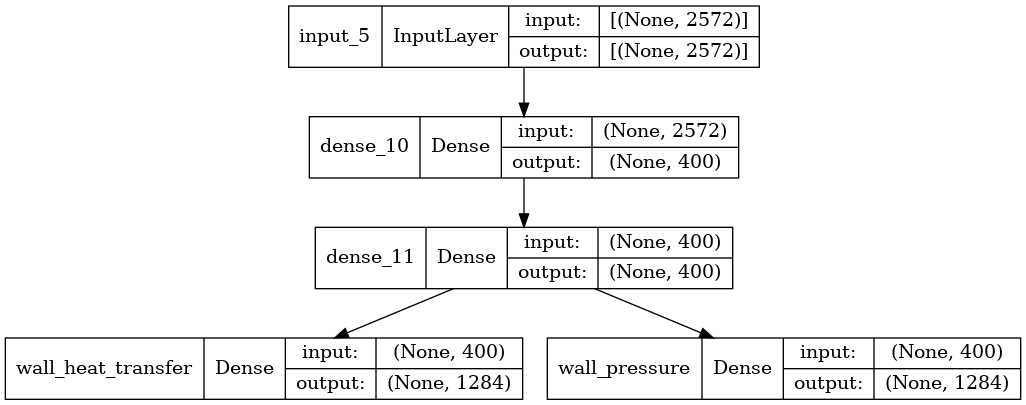

In [ ]:
# build this one so you just type the date and it populates all the strings/pkls/paths, etc. 

if loadMultiFidelityNN: 
    # Loading the NN is a bit easier-- but you'll need to specify the path. An example path is included already, which will need to be edited if you wish to load a different model. 
    path = '/home/tyty/Desktop/CFD_Files/MFmodelTestData/MF_NN_2022-03-20' # specify desired model 
    os.chdir(path)
    loadedModelName = 'MF_NN'

    locals()[loadedModelName] = keras.models.load_model(path)

### Load History and Epochs

    # some time later... load the model from disk

    # path variable should already be defined from when you loaded the NN model. If not, uncomment the 2 lines below. 
    # path = '/home/tyty/Desktop/CFD_Files/MFmodelTestData/HF_NN_2022-02-11'
    # os.chdir(path)

    epochsFilename = 'MF_NN_epochs_2022-03-20.pkl'
    historyFilename = 'MF_NN_history_2022-03-20.pkl'

    desiredLoadedEpochsName = 'MF_NN_epochs'
    desiredLoadedHistoryName = 'MF_NN_history'

    locals()[desiredLoadedEpochsName] = pickle.load(open(epochsFilename, 'rb'))
    locals()[desiredLoadedHistoryName] = pickle.load(open(historyFilename, 'rb'))
    
tf.keras.utils.plot_model(MF_NN,show_shapes=True)

### Generate Predicitions

In [ ]:
HFinputTrainingData = inputTrainingData #for now, let's change this later to see how the model performs

lowFidelityNN_input = LF_NN.predict(HFinputTrainingData)

flattenedLowFidelityNN_input = np.concatenate((lowFidelityNN_input[0],lowFidelityNN_input[1]),
                                    axis = 1)

HFinputTrainingDataNumpy = np.array(HFinputTrainingData).reshape(4,400)

multiFidelityNN_input = np.concatenate((HFinputTrainingDataNumpy.T,flattenedLowFidelityNN_input),
                                    axis = 1)

MF_NN_predicted = MF_NN.predict(multiFidelityNN_input)

In [ ]:
# # Directly feeding the low fidelity data into the model. No predictions from LF model. 

# HFinputTrainingData = inputTrainingData #for now, let's change this later to see how the model performs

# flattenedLowFidelityNN_input = np.concatenate((q_lowFidelity, p_lowFidelity_SE),
#                                     axis = 1)

# HFinputTrainingDataNumpy = np.array(HFinputTrainingData).reshape(4,400)

# multiFidelityNN_input = np.concatenate((HFinputTrainingDataNumpy.T,flattenedLowFidelityNN_input),
#                                     axis = 1)

# MF_NN_predicted = MF_NN.predict(multiFidelityNN_input)

### Scale Predictions

In [ ]:
[qw_predicted, p_predicted] = MF_NN.predict(multiFidelityNN_input)

outputPredictedData = []

print('\nPredicted Output Data (stored in list outputPredictedData):\n')
for i, name in enumerate(outputVarNames):
    ScalerName = name + '_OutputScaler'
    OutputDataName = name + '_predicted'
    locals()[OutputDataName] = locals()[ScalerName].inverse_transform(globals()[OutputDataName])
    outputPredictedData.append(locals()[ScaledName])
    max_element = str(round(np.max(locals()[OutputDataName]),2))
    min_element = str(round(np.min(locals()[OutputDataName]),2))
    print(OutputDataName + ' has been inverse transformed! It is called ' + OutputDataName + '. Min:' + min_element + '. Max:' + max_element)


Predicted Output Data (stored in list outputPredictedData):

qw_predicted has been inverse transformed! It is called qw_predicted. Min:-89182.8. Max:14400916.0
p_predicted has been inverse transformed! It is called p_predicted. Min:1945.11. Max:1188467.0


### Analyze Predictions (One to One Comparison)

Text(0.5, 24.0, 'Predicted Pressure')

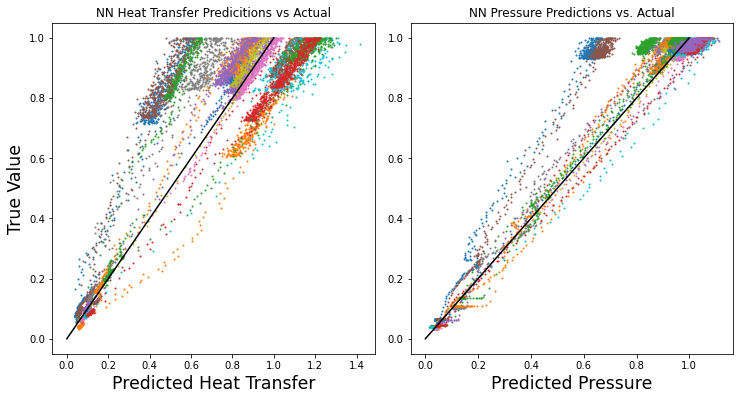

In [ ]:
desiredNumCasesForPlot = 15
casePlotRange= np.arange(0,400,int((400/desiredNumCasesForPlot)))

plt.rcParams["figure.figsize"] = (10,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)
fig.patch.set_facecolor('white')

  
for i, case in enumerate(casePlotRange):
    labelstr = 'Case: ' + str(case)
    maxHeatTransfer = qw[case,:].max()
    maxPressure = p[case,:].max()
    axs[0].scatter(qw_predicted[case,:]/maxHeatTransfer,qw[case,:]/maxHeatTransfer, s=1, label = labelstr )
    axs[1].scatter(p_predicted[case,:]/maxPressure,p[case,:]/maxPressure, s=1, label = labelstr)


axs[0].plot([0, 1], [0, 1], color = 'k')
axs[1].plot([0, 1], [0, 1], color = 'k')
# axs[0].scatter(qw_predicted[389,:],qw[389,:], s=1, label = 'Case 389' )
# axs[1].scatter(p_predicted[389,:],p[389,:], s=1)

axs[0].set_title("NN Heat Transfer Predicitions vs Actual")
axs[1].set_title("NN Pressure Predictions vs. Actual")
axs[0].grid()
axs[1].grid()
axs[0].set_ylabel("True Value")
axs[0].set_xlabel("Predicted Heat Transfer")
axs[1].set_xlabel("Predicted Pressure")

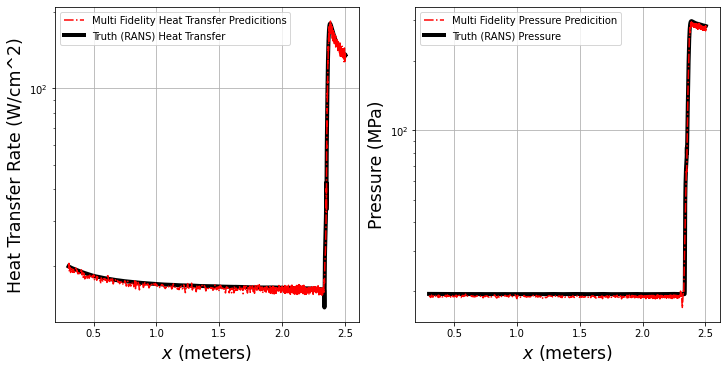

In [ ]:
caseWePick = random.randint(0,399)
caseWePick = 225
sliceVal = 25 # this is the "ol' fashioned way" for the plt.plot argument "markevery=sliceVal." The command doesn't work in plt.scatter
plt.rcParams["figure.figsize"] = (10,5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=1.2, w_pad=2.5, h_pad=.5)
fig.patch.set_facecolor('white')

axs[0].semilogy(x_cc_windowed[0,:],qw_predicted[caseWePick,:]/10000,
                label = 'Multi Fidelity Heat Transfer Predicitions', linestyle = '-.', color = 'red', zorder=3)
axs[0].semilogy(x_cc_windowed[0,:],qw[caseWePick,:]/10000,
                label = 'Truth (RANS) Heat Transfer',color='black', linestyle='solid',
                linewidth=4)

# axs[0].scatter(
#     x_cc_windowed[0,::sliceVal],
#     qw_predicted[caseWePick,::sliceVal],
#     c='white', zorder=3,edgecolors='black', marker='D', s=70, label='Neural Network Predicition')

axs[1].semilogy(x_cc_windowed[0,:],p_predicted[caseWePick,:]*1e-3,
                label = 'Multi Fidelity Pressure Predicition', linestyle = '-.', color = 'red',zorder=3)
axs[1].semilogy(x_cc_windowed[0,:],p[caseWePick,:]*1e-3, 
                label = 'Truth (RANS) Pressure',color='black', linestyle='solid',
                linewidth=4)
# axs[0].scatter(
#     x_cc_windowed[0,::sliceVal],
#     qw_predicted[caseWePick,::sliceVal],
#     c='white', zorder=3,edgecolors='black', marker='D', s=70, label='Neural Network Predicition')


# xlim([min(x)-.1 max(x)+.1])
axs[0].set_xlabel('$x$ (meters)')
axs[0].set_ylabel('Heat Transfer Rate (W/cm^2)')

axs[1].set_xlabel('$x$ (meters)')
axs[1].set_ylabel('Pressure (MPa)')

axs[0].legend()
axs[1].legend()

In [ ]:
caseWePick

225

### Analyze MSE in MF Neural Networks

Text(0.5, 1.0, 'Pressure Mean Squared Error, MF NN')

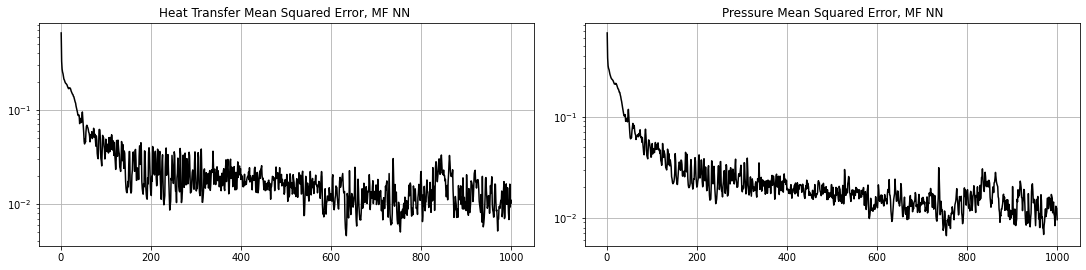

In [ ]:
###### Multi Fidelity Mean Squared Error
qw_mse_history_mfNN = MF_NN_history["wall_heat_transfer_mean_squared_error"]
p_mse_history_mfNN = MF_NN_history["wall_pressure_mean_squared_error"]

plt.rcParams["figure.figsize"] = (15,3.5)
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0.4, w_pad=2.0, h_pad=1.5)
fig.patch.set_facecolor('white')

axs[0].semilogy(
    range(1,len(qw_mse_history_mfNN[:]) + 1),
    qw_mse_history_mfNN[:],
    linestyle="-",
    color="k")
axs[0].set_title("Heat Transfer Mean Squared Error, MF NN ")


axs[1].semilogy(
    range(1,len(p_mse_history_mfNN[:]) + 1),
    p_mse_history_mfNN[:],
    linestyle="-",
    color="k")
axs[1].set_title("Pressure Mean Squared Error, MF NN")